# Device Featurizer

This notebook is the first generation of feature extraction algorithms for device degradation modeling, with the aim of predicting JSC-75, VOC-75, and PCE-75. The skeleton is the same as for films, but the feature set will be different in most cases.

In [1]:
# standard imports as well as some additional ones for machine learning, plotting etc.
# farther down the cell are some functions 
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.integrate import trapz
import scipy as sp
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from os import listdir
import sys
sys.path.append('../')
import SQ_calcs
import json
import os
%matplotlib inline
import glob
from collections import OrderedDict
import seaborn
import itertools

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics
import datetime as dt

from skimage.io import imread
from matplotlib import transforms
from scipy.optimize import curve_fit

#change default plot settings
mpl.style.use('wiley_publication.mplstyle')

plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

## Useful functions used frequently defined below:

# function to correlate variables, calculate Pearson r, and plot results
def pearson_correlation(x,y,x_lab,y_lab):
    plt.figure()
    plt.plot(x,y,'.')
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    #infinites = np.logical_or(np.isfinite(x), np.isfinite(y))
    #invalids = np.logical_or(nas,infinites)
    z = scipy.stats.pearsonr(x[~nas],y[~nas])
    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),1.2*np.max(y))
    plt.text(0.5*(np.min(x)+np.max(x)),1.1*np.max(y),np.round(z,decimals=3))
    #print(np.round(z,decimals=3))

def bleach_rate_from_pct_increase(threshold,t,Tr):
# arguments: threshold: relative increase in norm. transmittance used to define belaching rate
#            t: time series, in minutes
#            Tr: normalized transmittance timeseries
#
    # first find index at which normalized transmittance increases beyond threshold
    for kk in range(len(Tr)):
        if Tr[kk] > threshold:
            break
    
    # if the loop gets to the end without crossing the threshold, assign NaN value to the bleaching rate
    if kk == len(Tr)-1:
        tau = np.nan
    else:
    # do linear interpolation between points just above and just below threshold to get 
    # "failure" time at exactly the threshold
        tau = t[kk-1] + (t[kk]-t[kk-1])*(threshold-Tr[kk-1])/(Tr[kk]-Tr[kk-1])
    
    # invert "failure time" to get bleaching rate, in 1/min
    bleach_rate = (threshold-1)/tau
    
    # return the bleaching rate
    return bleach_rate

# alternative way to extract bleaching rate: instead of taking secant approximation to degradation rate, 
# perform a linear fit to all the data up to the threshold and ignore everything else;
# if the threshold can't be reached, just fit the entire dataset
def bleach_rate_from_linear_fit_to_pct_increase(threshold,t,Tr):
# arguments: threshold: relative increase in norm. transmittance used to define belaching rate
#            t: time series, in minutes
#            Tr: normalized transmittance timeseries
#
    # first find index at which normalized transmittance increases beyond threshold
    for kk in range(len(Tr)):
        if Tr[kk]/Tr[0] > threshold:
            break
    
    # use linear polynomial fit up to threshold
    coeffs = np.polyfit(t[:kk+1],Tr[:kk+1],1)
    bleach_rate = coeffs[0]
    intercept = coeffs[1]
    
    # return the bleaching rate
    return bleach_rate, intercept

# return complement of a list (first) with respect to another (second)
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

# define function for handling marker styles when plotting to reflect 
# the environmental conditions used for a given data point
def envt_plot_style(temp,rh,o2,illum,encap):
    if temp < 15:
        m_color = np.array([0.00,0.00,0.20])
    elif 15 < temp <= 35:
        m_color = np.array([0.00,0.20,0.20])
    elif 35 < temp <= 55:
        m_color = np.array([0.00,0.20,0.00])
    elif 55 < temp <= 75:
        m_color = np.array([0.20,0.20,0.00])
    elif 75 < temp:
        m_color = np.array([0.20,0.00,0.00])

    # humidity encoded by brightness
    if rh < 10:
        m_color *= 1
    elif 10 < rh < 30:
        m_color *= 2
    elif 30 < rh < 50:
        m_color *= 3
    elif 50 < rh < 70:
        m_color *= 4
    elif 70 < rh:
        m_color *= 5

    # illumination encoded by marker shape
    if illum == 8:
        m_shape = 'o'
    elif illum == 32:
        m_shape = 'D'
    elif illum == 1:
        m_shape = 'v'
    elif illum == 16:
        m_shape = 's'
    elif illum == 0:
        m_shape = 'p'
    elif illum == 4:
        m_shape = 'h'
    elif illum == 0.5:
        m_shape = '^'

    # oxygen level encoded by marker fill
    if o2 < 20:
        m_fill = 'none'
    elif o2 < 50:
        m_fill = 'right'
    else:
        m_fill = 'full'

    # encapsulation encoded by line style
    if encap == 'none':
        l_style = ' '
    elif encap == '5mgmL_PMMA':
        l_style = '--'
    elif encap == '10mgmL_PMMA':
        l_style = '-'
    else:
        l_style = ' '

    return m_color, m_shape, m_fill, l_style

def plot_residuals(resids):
    plt.figure()
    _, bins, _ = plt.hist(resids)
    resid_mean = np.mean(resids)
    resid_sd = np.std(resids)
    resid_x=np.linspace(np.min(resids),np.max(resids),num=100)
    norm_dist = np.exp(-0.5*((resid_x-resid_mean)/resid_sd)**2)/(resid_sd*np.sqrt(2*np.pi))
    scale = len(resids)*(bins[1]-bins[0])
    plt.plot(resid_x,norm_dist*scale)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Residuals Histogram')    
            
# interpolate early time features to a universal time range (default is 10 min)
def interp_early_time(time_raw,timeseries,univ_horiz=10):

    idx = np.argmin(np.abs(time_raw-univ_horiz)) # index of datapoint closest to the horizon
    # if the nth index is at or below the horizon, increment by one;
    # otherwise, leave as is so as not to include predictions outside
    if time_raw[idx] >= univ_horiz:
        idx += 1
    else:
        idx += 2
    # interpolate from range of allowed indices to prediction horizon (5 points after start)
    series_interp_func = sp.interpolate.interp1d(time_raw[:idx],timeseries[:idx])
    t = np.linspace(0,univ_horiz,num=6)
    series_interp = series_interp_func(t)

    return(series_interp[-5:])

# gaussian function for curve fitting:
#    x: independent variable
#    sigma: standard deviation
#    mu: peak center (mean)
#    amp: peak height
#    base: baseline value (avoid fitting PL over Au contacts)
def gaussian(x, sigma, mu, amp, base):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2)) + base

# for getting rid of corrupted data and replacing with interpolated approximations
def scrub_instrument_malfunction(timeseries,bad_points):
    # remove bad points caused by instrument malfunction by interpolating from the adjacent points
    # timeseries: array or array-like containing points to interpolate
    # bad_points: tuple of tuples: each inner tuple represents the endpoints (inclusive) of each region of bad data
    #             in the timeseries if containing two elements, or an isolated bad point if containing only one element
    # CAVEAT: only works right now for timeseries with equally spaced datapoints
    
    # if there are multiple disjoint malfunction regions:
    if type(bad_points) == tuple:
        # scan over tuples identifying missing points
        for bp_idx in bad_points:
            # if the point is isolated, recalculate as average of adjacent points
            if type(bp_idx) == int:
                 timeseries[bp_idx] = 0.5*(timeseries[bp_idx+1] + timeseries[bp_idx-1])
            # otherwise, linearly interpolate between the two points adjacent to the range
            else:
                a = bp_idx[0] # first bad data point
                b = bp_idx[1] # 
                interp_range = b + 2 - a
                m_idx = a # missing indices
                # while still in the missing index range, keep interpolating points
                while m_idx < (b+1):
                    timeseries[m_idx] = (m_idx - a + 1)*(timeseries[b+1] - timeseries[a-1])/interp_range + timeseries[a-1]
                    m_idx += 1
   
    # otherwise, for a single isolated point in the entire timeseries:
    else:
        bp_idx = bad_points
        timeseries[bp_idx] = 0.5*(timeseries[bp_idx-1] + timeseries[bp_idx+1])
        
    # return the scrubbed timeseries
    return timeseries

In [2]:
# In this cell: load all the data

# Paths to directories containing data you wish to analyze

# Basic directory on Drive corresponding to where the post-pipeline timeseries data are stored
EP1 = 'G:/Shared drives/Effort_Perovskites/Machine_Learning/Data/Timeseries/'
EP2 = 'G:/Shared drives/Effort_Perovskites_2/Machine_Learning/Data/Timeseries/'
EP3 = 'G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/'
EP4 = 'G:/.shortcut-targets-by-id/1rh4PCuoh_akdaVnq0_EfX19c0izf-agD/Effort_Perovskites_4/Machine_Learning/Data/Timeseries/'


############# FREQUENTLY NEEDS EDITING ##############
# Specify which experiments within a given class to analyze - in this case we are getting all of them
expt_list = [EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_40RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_50RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_45C_40RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_45C_60RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_45C_50RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_25C_40RH_air_bad_DF',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_45C_40RH_air_2',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_25C_30RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_25C_70RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_45C_70RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_60RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_45C_30RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_70RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_70RH_air_2',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_30RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_65C_40RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_85C_40RH_air',
             EP3 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_75C_40RH_air',
             EP3 + '210122_Schrodingers_Perovskite/P38_X-6_fullsuite',
             EP3 + '210122_Schrodingers_Perovskite/P38-3-8_unsteady_bias_and_light',
             EP3 + '210122_Schrodingers_Perovskite/W86-5-8_unsteady_bias_and_light',
             EP3 + '210122_Schrodingers_Perovskite/WDS84-1-8_unsteady_bias_and_light',
             EP3 + '210122_Schrodingers_Perovskite/YM5-1-3_Full_Suite_15min_50RH',
             EP3 + '210122_Schrodingers_Perovskite/YM5-6-5_Full_Suite_15min',
             EP3 + '210122_Schrodingers_Perovskite/YM5-12-3_Full_Suite_15min_60RH',
             EP3 + '210122_Schrodingers_Perovskite/WDS84-11-8_MPPT_Only',
             EP4 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_30RH_air_2',
             EP4 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_85C_50RH_air_bad_DF',
             EP4 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_85C_60RH_air_bad2',
             EP4 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_85C_60RH_air',
             EP4 + '210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_55C_40RH_air',
            ]

# expt_list = list(itertools.chain(expt_list1,expt_list2))

# make sure that the correct experiments are being read in
# for expt in expt_list:
#     print(expt)
    
# problem runs to avoid
bad_list = []

# these are not separate runs but continuations of other ones
duplicate_list = []   
# in some cases, it may be convenient to add new runs to an already featurized dataset, in which case provide a
# CSV file to compare; to avoid duplicating runs that have already been featurized, double check beforehand
# to save analysis time


print('Number of Runs: ',len(expt_list)-len(bad_list)-len(duplicate_list))

# specify missing/corrupt data to be interpolated around or simply removed

# problems with cv_slopes parameter
dropout_cv_dict = {'JV_PL_DF_MAPI_1sun_25C_70RH_air': (2)} # dictionary: keys: string corresponding to the run in question
                                                           #             values: tuple of problem locations

# problems with JV related quantities
dropout_JV_dict = {'W86-5-8_unsteady_bias_and_light':[73,74,75,76,103]}

appending_to_old_CSV = False

Number of Runs:  31


G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_40RH_air
False
['G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_40RH_air/primary_vids\\YM7-2-2_grad0_loc0_time0']
Experiment started at:
2021-04-12 20:52:05 -0700
G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_50RH_air
False
['G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_50RH_air/primary_vids\\YM7-12-6_grad0_loc0_time0']
Experiment started at:
2021-04-26 19:55:16 -0700
G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210412_MAPI_Devices/

Experiment started at:
2021-07-12 12:13:56 -0700
G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_75C_40RH_air
False
['G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_75C_40RH_air/primary_vids\\YM15-4-2_grad0_loc0_time0']
Experiment started at:
2021-07-13 16:09:55 -0700
G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210122_Schrodingers_Perovskite/P38_X-6_fullsuite
False
['G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210122_Schrodingers_Perovskite/P38_X-6_fullsuite/primary_vids\\P38_A-6_grad0_loc0_time0']
Experiment started at:
2021-02-22 11:37:18 -0800
G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Le

<ipython-input-5-29a71c2cfcd7>:795: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16,8))


['G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210122_Schrodingers_Perovskite/WDS84-1-8_unsteady_bias_and_light/primary_vids\\WDS84-1-8_grad0_loc0_time0']
Experiment started at:
2021-01-25 17:50:02 -0800
G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210122_Schrodingers_Perovskite\WDS84-1-8_unsteady_bias_and_light_ctd
['G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210122_Schrodingers_Perovskite\\WDS84-1-8_unsteady_bias_and_light_ctd/primary_vids\\WDS84-1-8_grad0_loc0_time0']
Next chunk started at:
2021-01-25 22:00:16 -0800
Total time elapsed since start of run (min):
250.0
MicroManager Only Crashed?  False
G:/.shortcut-targets-by-id/1QYKycHbBYmm38jHyBiIHndq6dxjR_RwH/Effort_Perovskites_3/Machine_Learning/Data/Timeseries/210122_Schrodingers_Perovskite/YM5-1-3_Full_Suite_15min_50RH
Fa

<ipython-input-5-29a71c2cfcd7>:466: RuntimeWarning: All-NaN axis encountered
  Jsc_maxnorm = Jsc/np.nanmax(Jsc)


G:/.shortcut-targets-by-id/1rh4PCuoh_akdaVnq0_EfX19c0izf-agD/Effort_Perovskites_4/Machine_Learning/Data/Timeseries/210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_30RH_air_2
False
['G:/.shortcut-targets-by-id/1rh4PCuoh_akdaVnq0_EfX19c0izf-agD/Effort_Perovskites_4/Machine_Learning/Data/Timeseries/210412_MAPI_Devices/JV_PL_DF_MAPI_1sun_35C_30RH_air_2/primary_vids\\YM16-12-8_grad0_loc0_time0']
Experiment started at:
2021-07-23 14:21:29 -0700
G:/.shortcut-targets-by-id/1rh4PCuoh_akdaVnq0_EfX19c0izf-agD/Effort_Perovskites_4/Machine_Learning/Data/Timeseries/210412_MAPI_Devices\JV_PL_DF_MAPI_1sun_35C_30RH_air_2_ctd
['G:/.shortcut-targets-by-id/1rh4PCuoh_akdaVnq0_EfX19c0izf-agD/Effort_Perovskites_4/Machine_Learning/Data/Timeseries/210412_MAPI_Devices\\JV_PL_DF_MAPI_1sun_35C_30RH_air_2_ctd/primary_vids\\YM16-12-8_grad0_loc0_time0']
Next chunk started at:
2021-07-26 08:37:15 -0700
Total time elapsed since start of run (min):
3976.0
MicroManager Only Crashed?  False
G:/.shortcut-targets-by-id/1rh4PCuo

,ClassID,ExptID,BatchID,Drive,Temp (deg C),RH (%),Oxygen (%),Illum (Nsuns),MA fraction,PLQY_0,...,ddxy3t1,ddbeta_mean,ddbeta_std,ddcv_slopes,t_Vocmax,t_FF90,t_Jsc90,DFCV_0,dDFCVdt,d2DFCVdt2
0,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_35C_40RH_air,YM7-2,EP3,35.0,40.0,21.0,1.0,1.0,0.001269,...,-0.001409,0.000052,-0.000355,-0.000091,1995.0,3615.0,270.0,0.750389,-0.000071,3.238634e-06
1,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_35C_50RH_air,YM7-12,EP3,35.0,50.0,21.0,1.0,1.0,0.001449,...,0.001116,0.001413,0.000425,0.000114,1515.0,1710.0,180.0,0.596792,-0.000038,3.184128e-06
2,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_40RH_air,YM7-10,EP3,45.0,40.0,21.0,1.0,1.0,0.001071,...,0.001661,-0.005678,0.000234,-0.000038,1275.0,1860.0,180.0,0.591911,0.000132,1.069293e-05
3,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_60RH_air,YM7-6,EP3,45.0,60.0,21.0,1.0,1.0,0.000880,...,-0.020725,0.004306,0.000409,0.000003,1080.0,1725.0,225.0,0.513487,0.000046,3.106067e-05
4,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_50RH_air,YM7-4,EP3,45.0,50.0,21.0,1.0,1.0,0.000981,...,0.001235,0.000031,0.000546,0.000120,930.0,2205.0,120.0,0.574408,-0.000053,2.444631e-06
5,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_25C_40RH_air_bad_DF,YM7-11,EP3,25.0,40.0,21.0,1.0,1.0,0.002146,...,-0.004941,0.000357,0.000262,-0.000177,2280.0,NaN,240.0,0.043219,-0.000025,6.183047e-07
6,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_40RH_air_2,YM7-3,EP3,45.0,40.0,21.0,1.0,1.0,0.000890,...,-0.000791,-0.000289,0.000079,0.000012,1140.0,2310.0,345.0,0.570685,-0.000050,-7.212151e-06
7,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_25C_30RH_air,YM7-5,EP3,25.0,30.0,21.0,1.0,1.0,0.001723,...,-0.001126,0.000568,0.000095,-0.000379,3300.0,NaN,300.0,0.548887,-0.000108,5.032375e-06
8,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_25C_70RH_air,YM12-2,EP3,25.0,70.0,21.0,1.0,1.0,0.002818,...,-0.025595,0.001027,0.000547,-0.000264,1020.0,1125.0,210.0,0.606112,-0.000090,7.132146e-05
9,210412_MAPI_Devices,JV_PL_DF_MAPI_1sun_45C_70RH_air,YM12-8,EP3,45.0,70.0,21.0,1.0,1.0,0.001173,...,-0.004745,0.001661,0.000432,0.000024,1290.0,2010.0,1020.0,0.600242,-0.000051,1.163450e-05


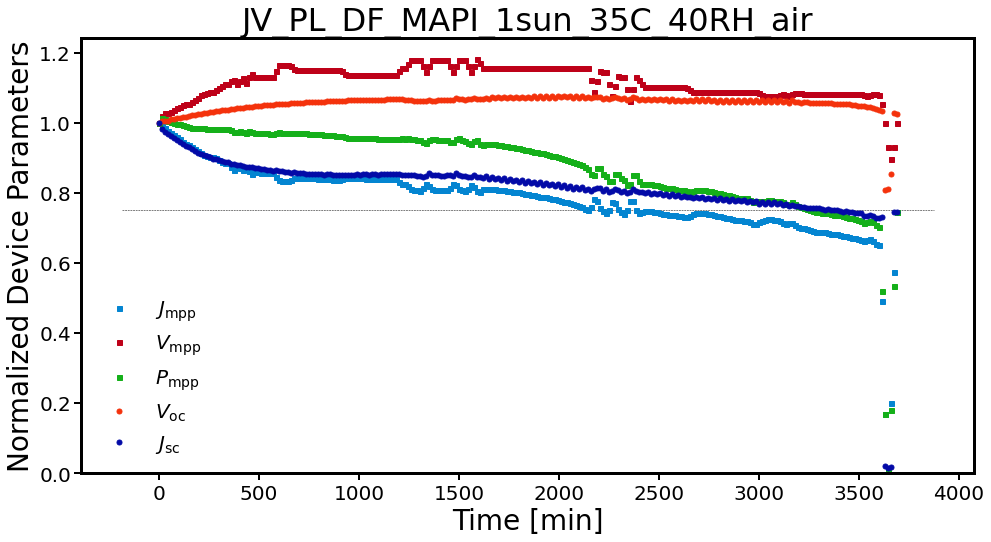

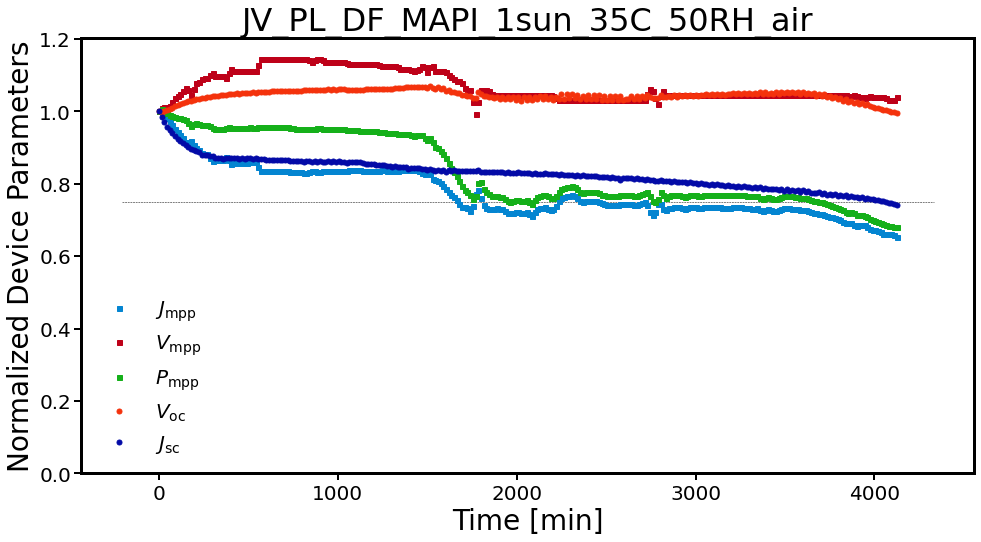

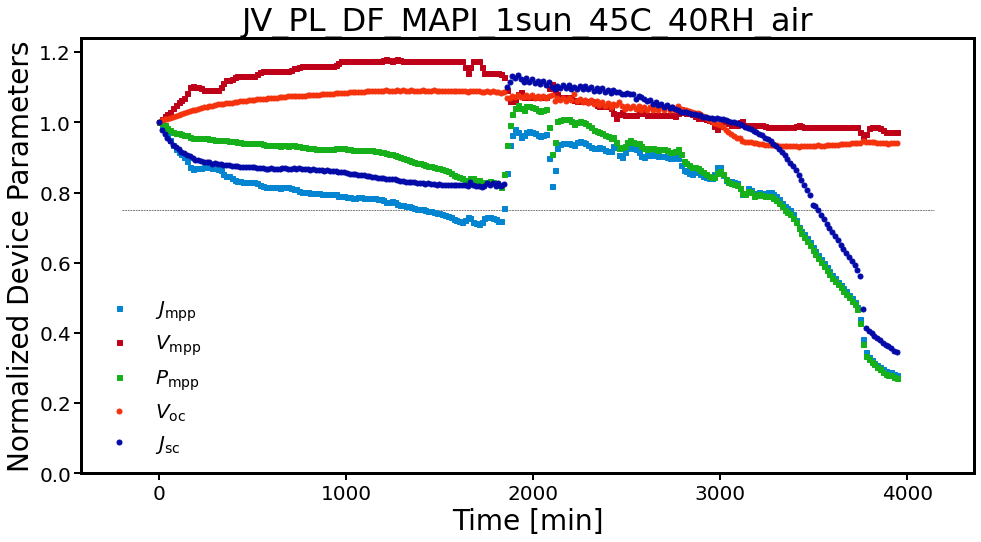

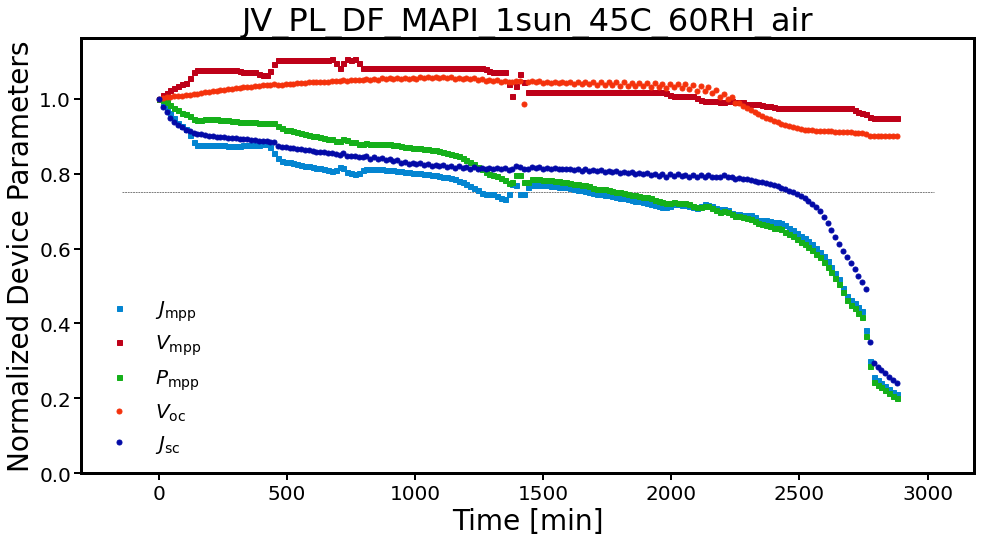

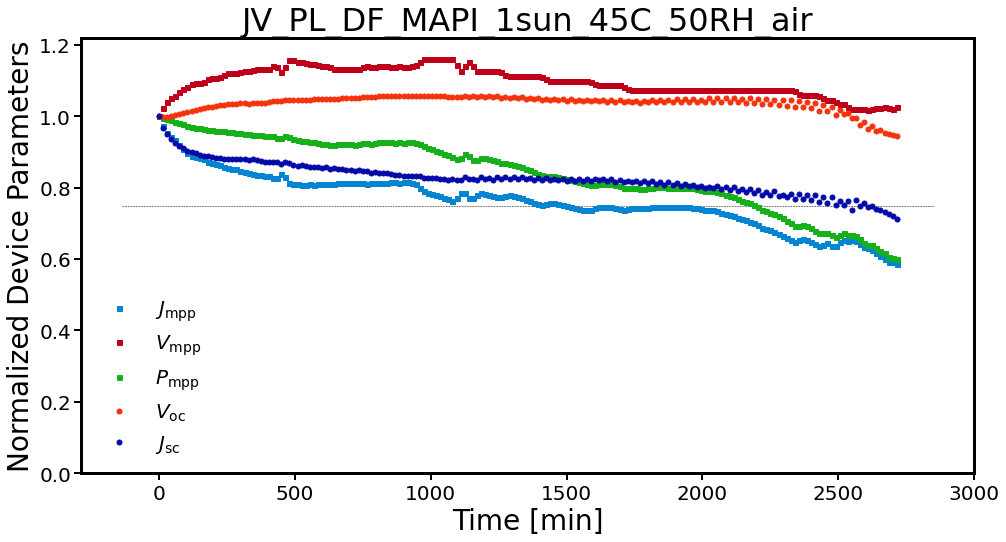

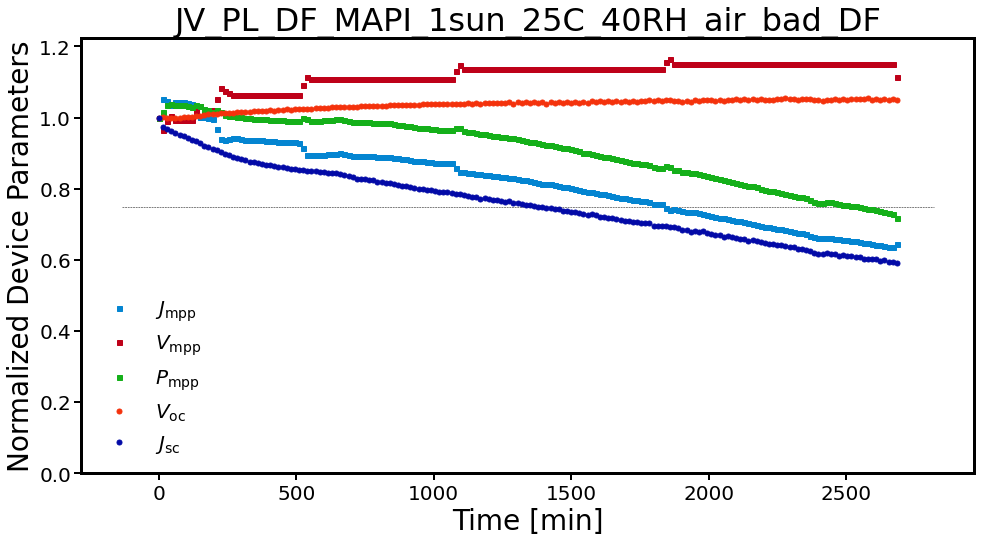

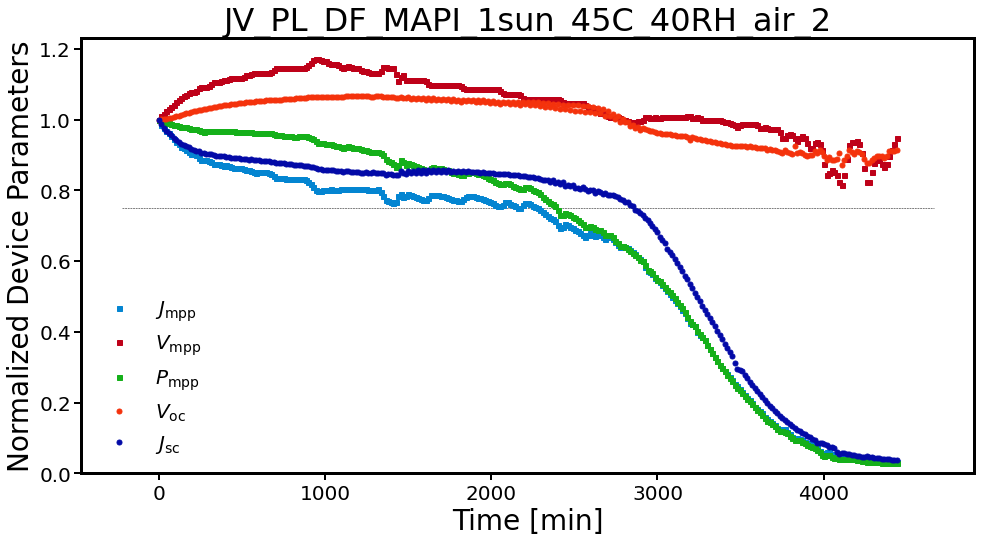

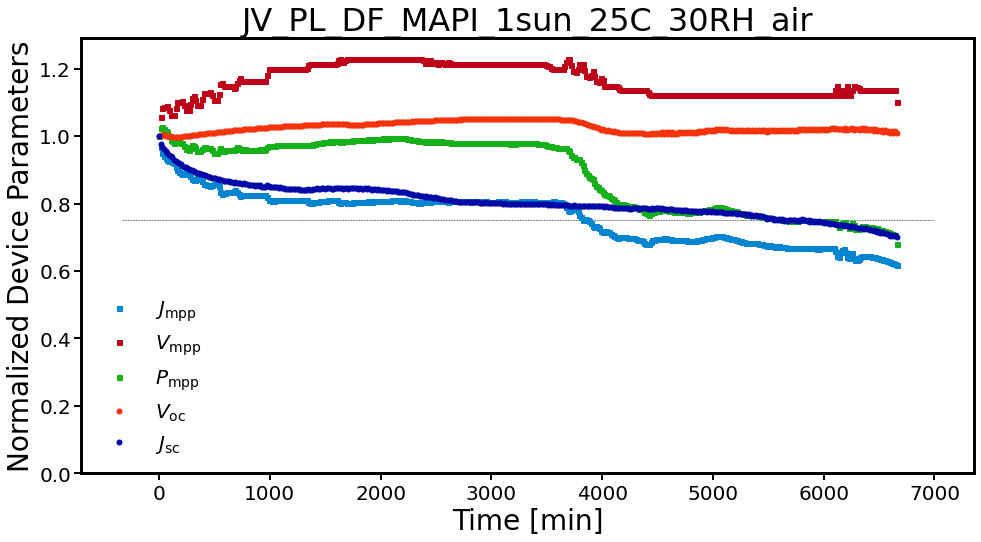

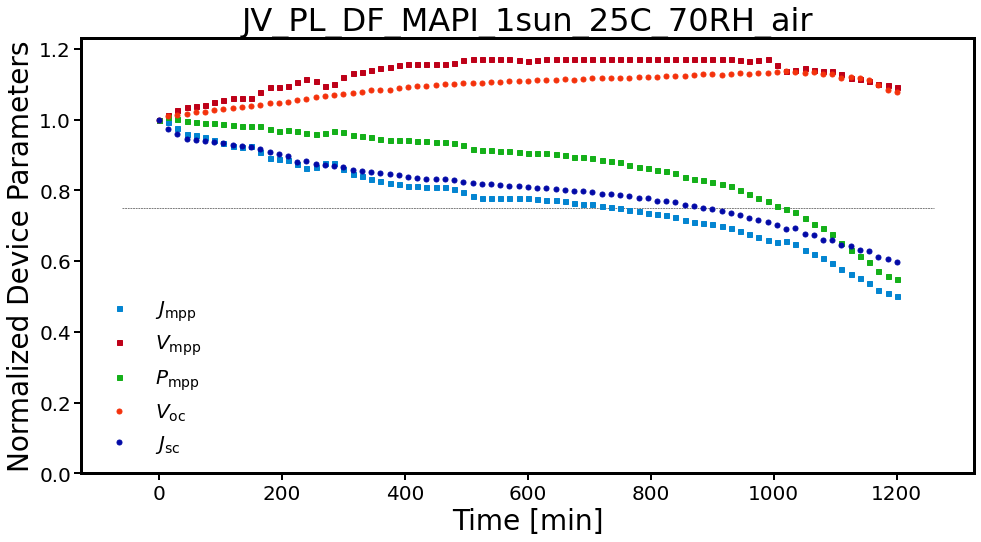

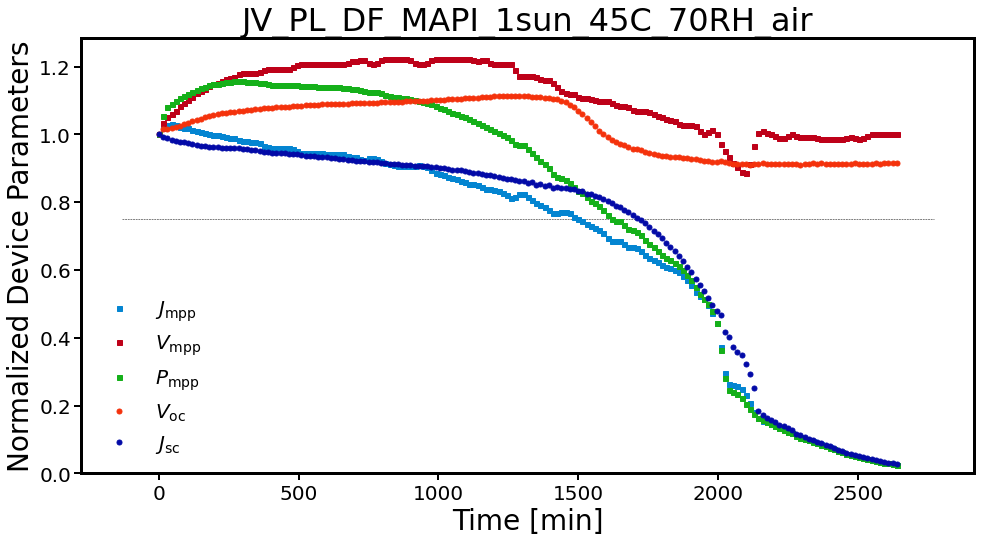

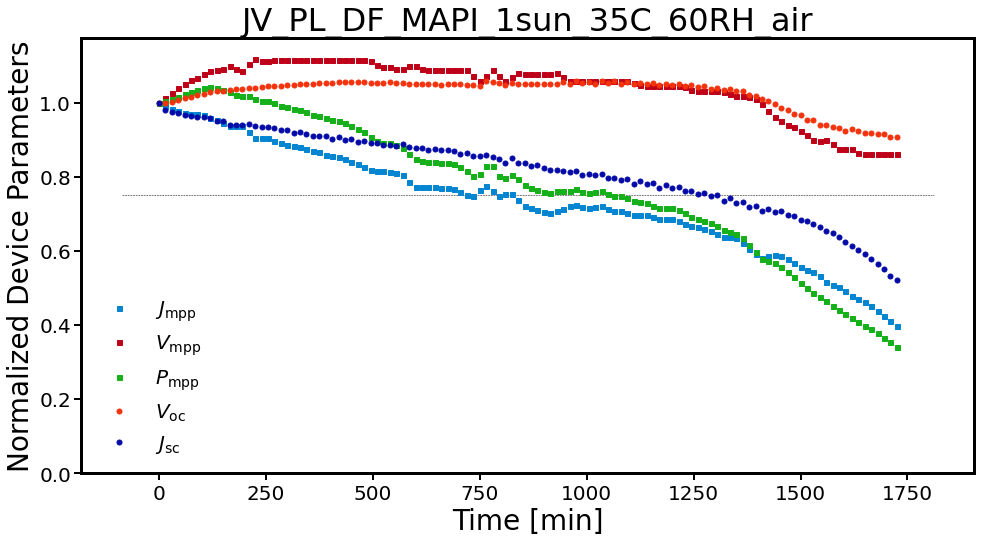

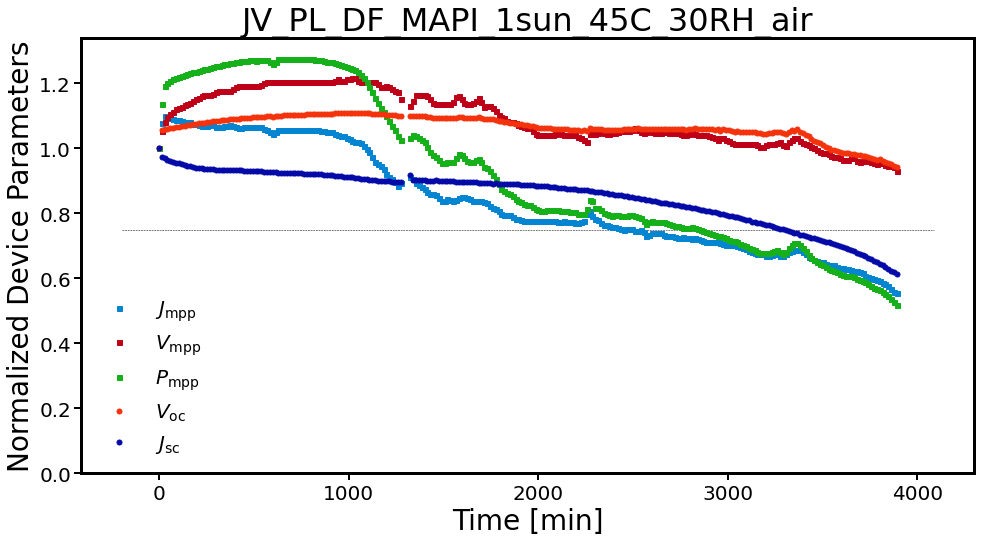

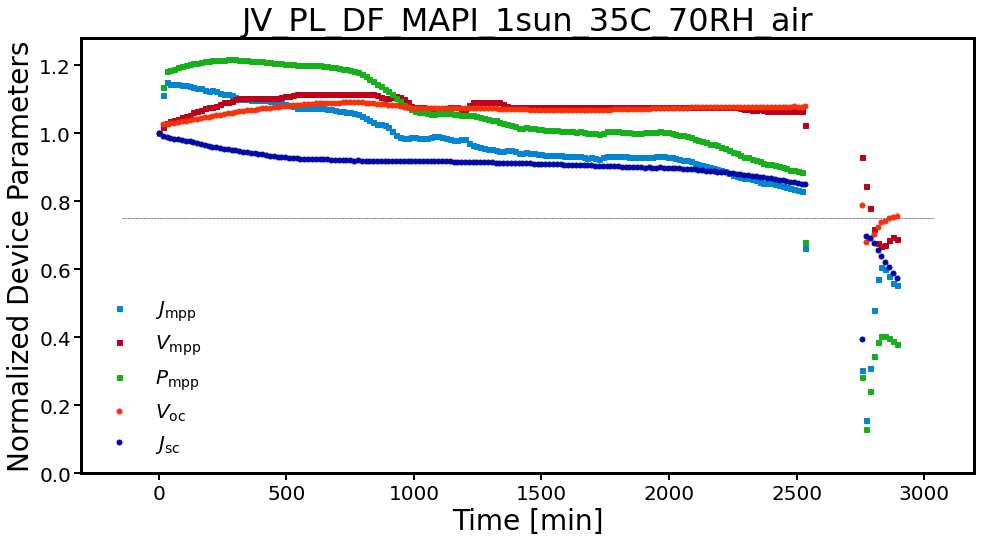

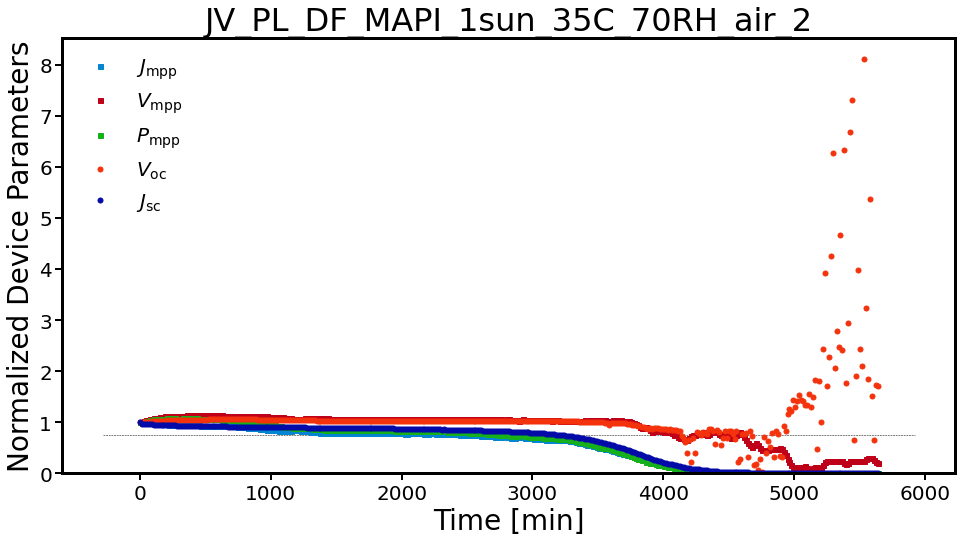

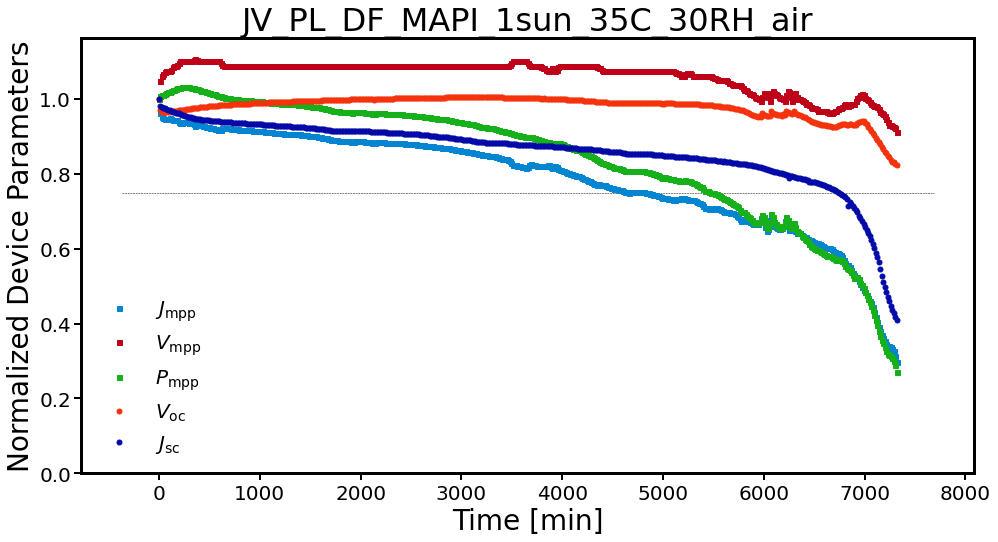

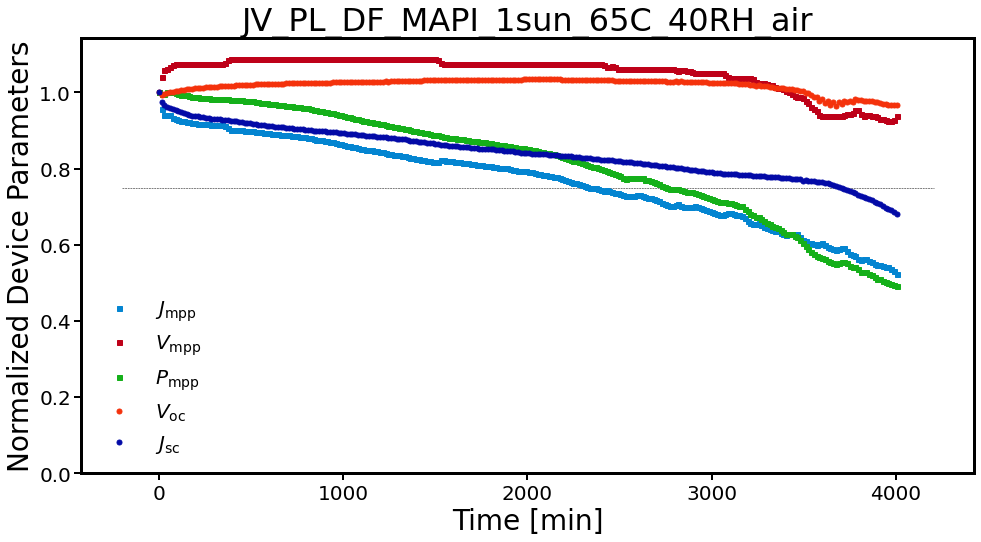

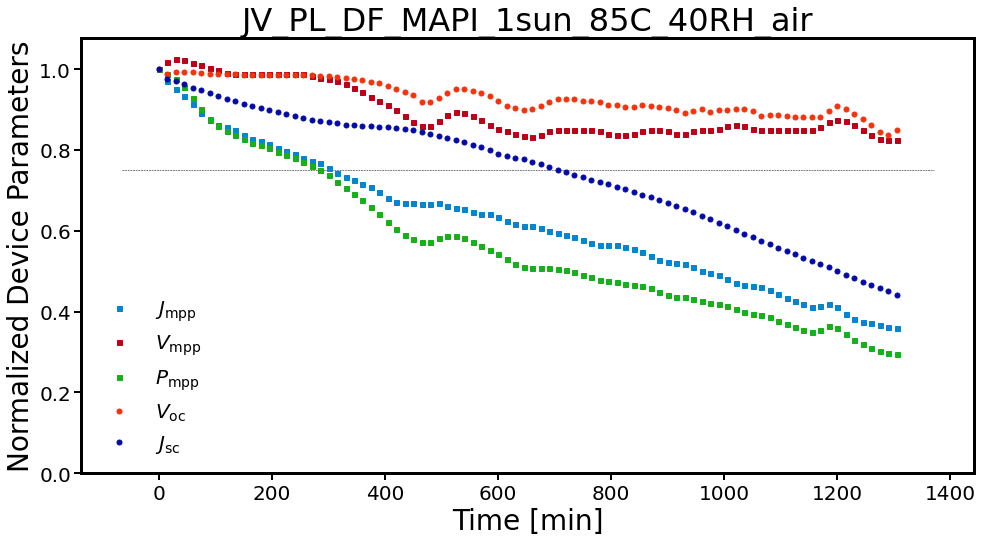

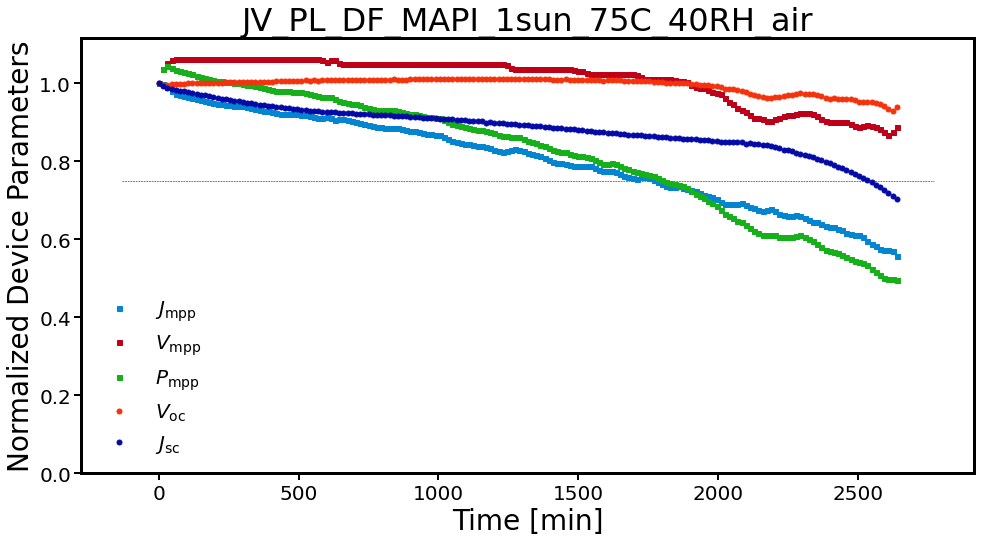

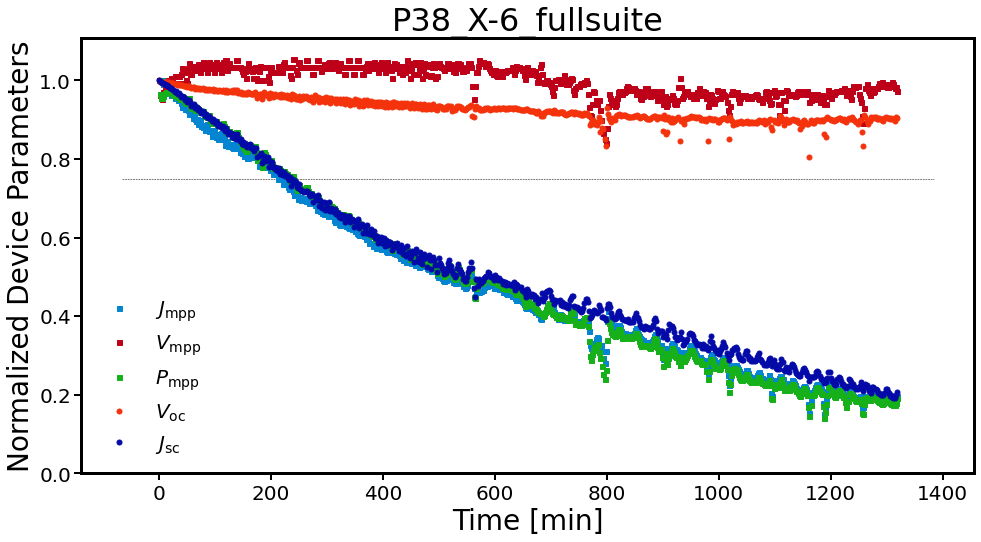

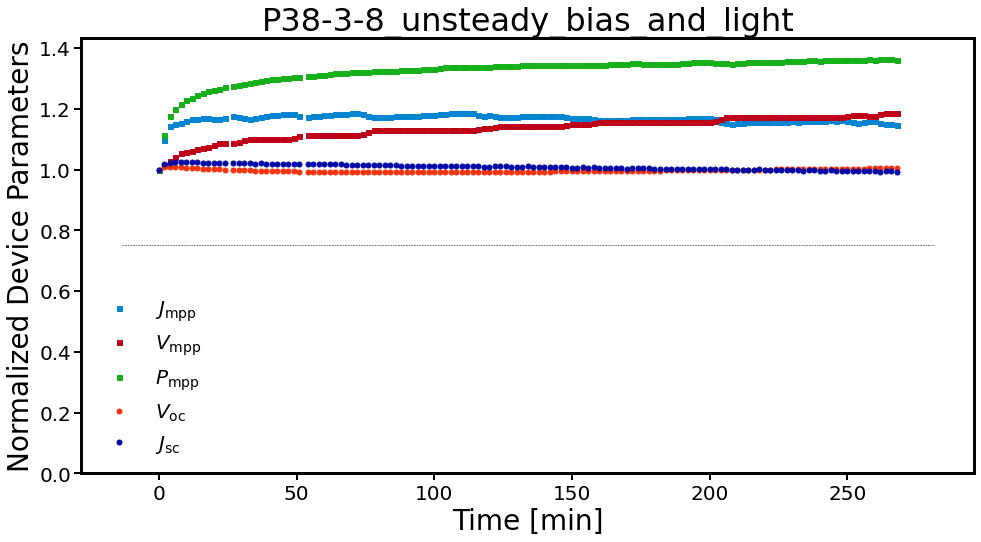

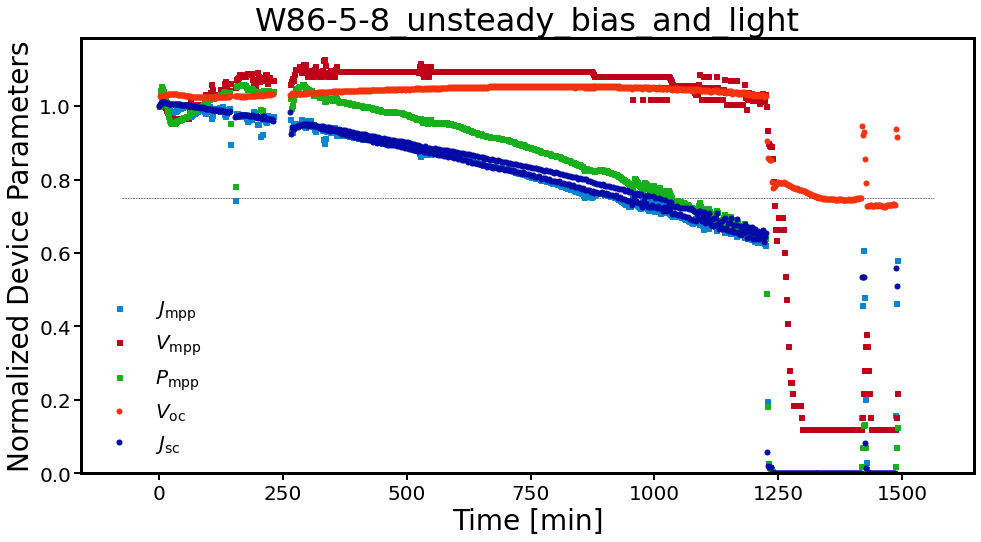

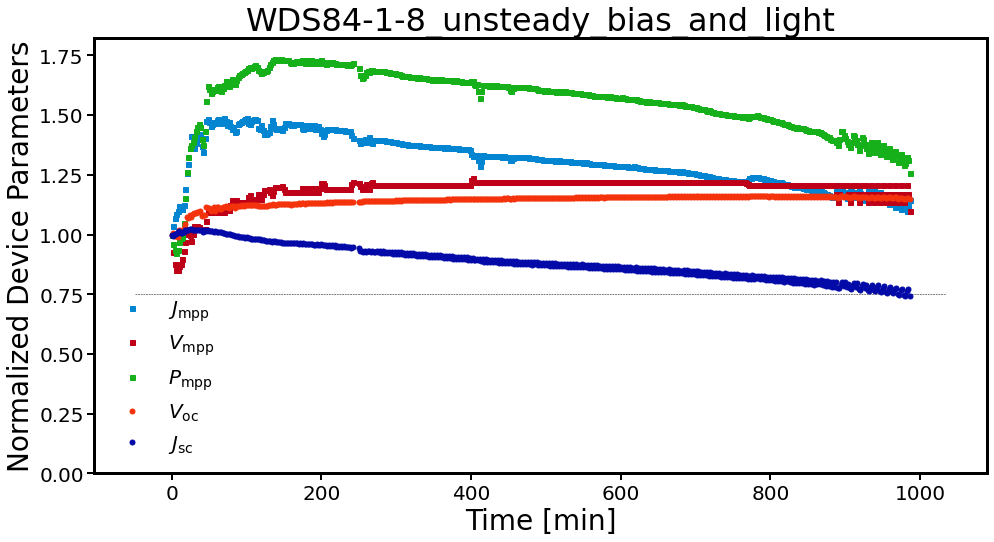

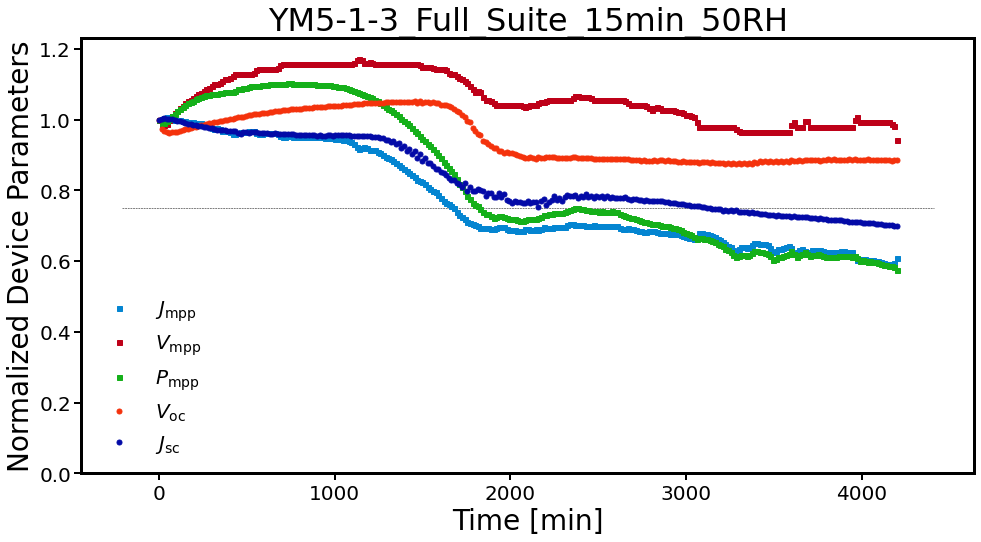

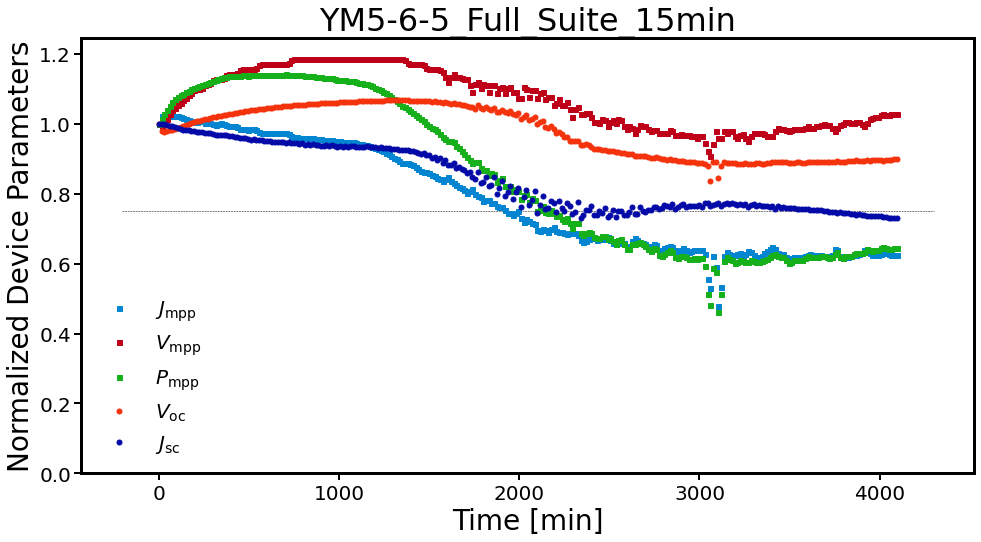

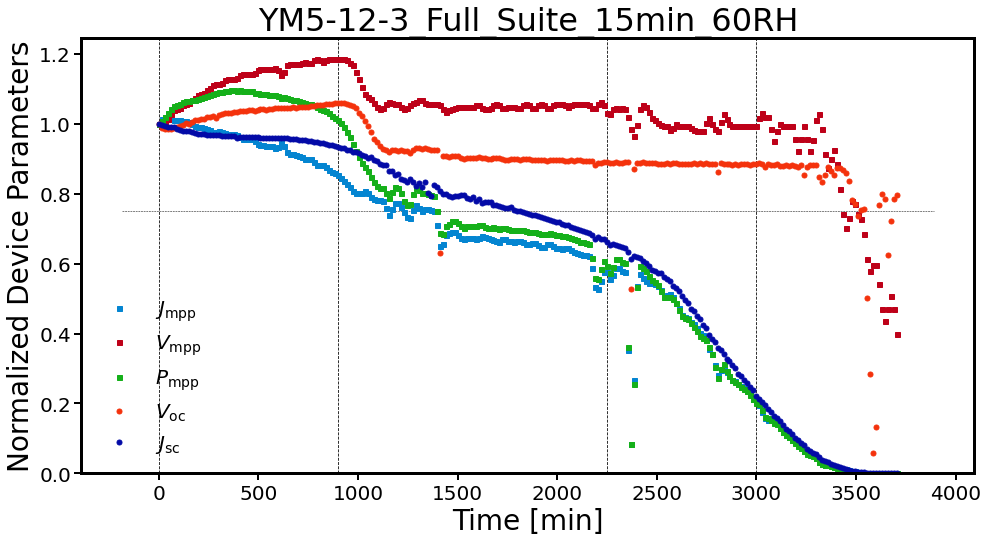

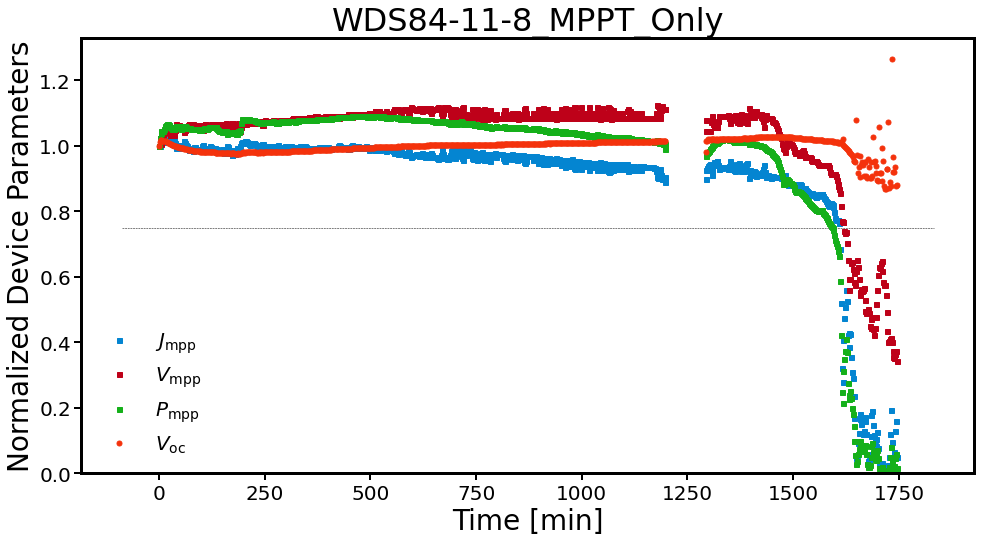

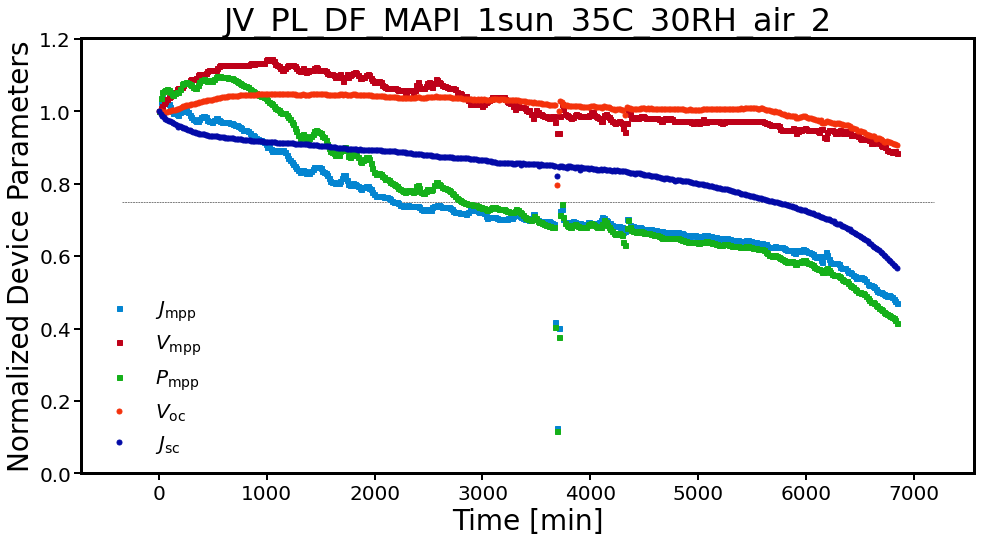

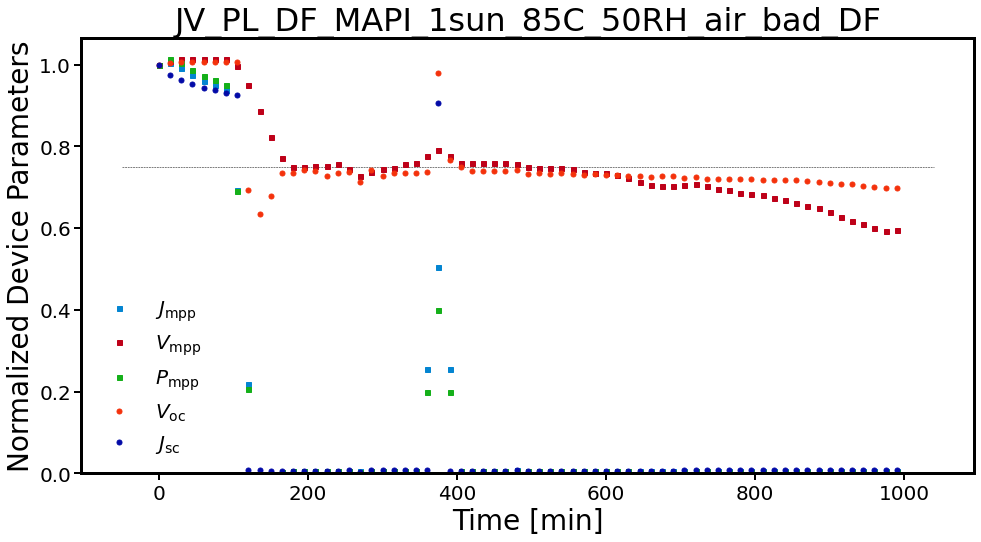

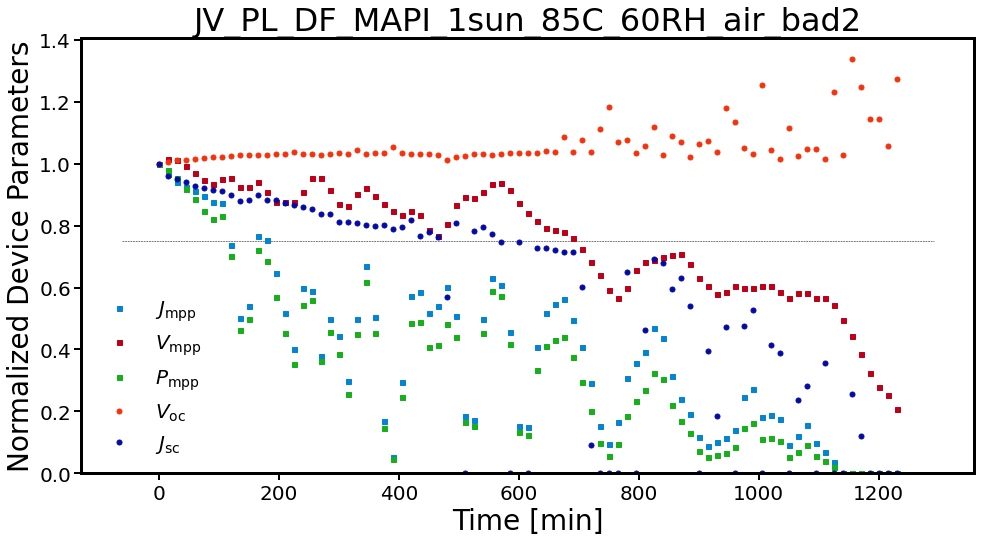

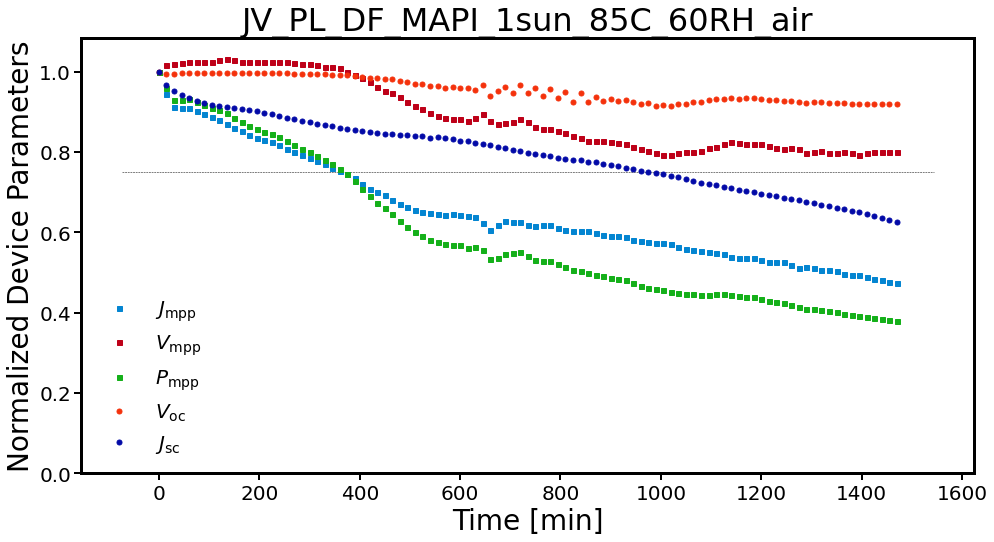

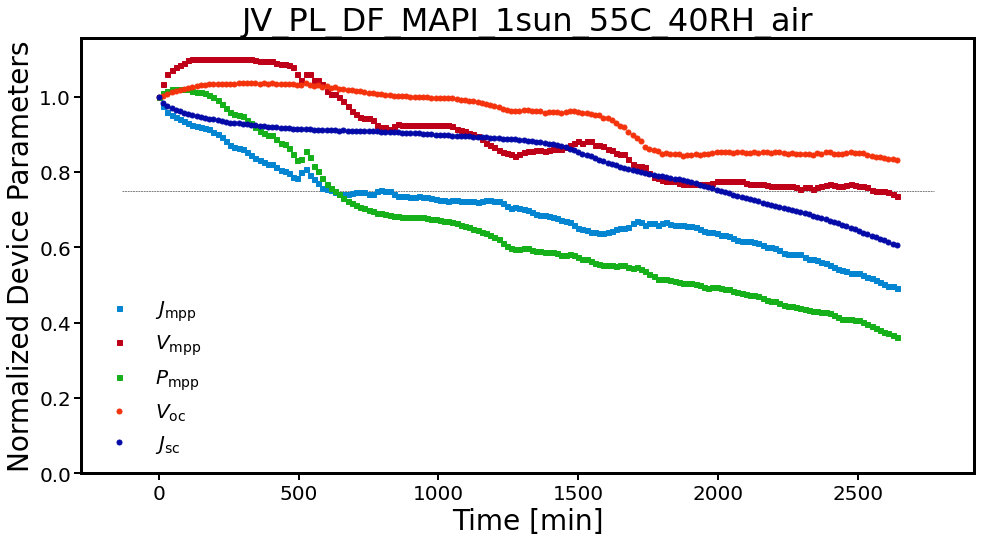

In [5]:
# how many points to use for early-time fitting
points_to_sample = 5

# initialize list of the experiment names and where to find them
ExptIDs = []
ClassIDs = []
BatchNos = []
Drives = []

# initialize array for factorial analysis for later conversion to dataframe
n_runs = len(expt_list)-len(bad_list)-len(duplicate_list)
n_feats_to_extract = 109
raw_data = np.zeros([n_runs,n_feats_to_extract])

# approximate transmittance of a pristine film, in absolute units
transmittance_t0 = 0.069
# approximate reflectance of a pristine film, in absolute units
reflectance_t0 = 0.215

# universal sample parameters and physical constants
Eg = 1.61 # material band gap, eV
photon_flux_1_sun = SQ_calcs.one_sun_photon_flux(Eg)
meas_V = 3 # measurement voltage, V
q = 1.602e-19 # electron charge, C
me = 9.109e-31 # electron mass, kg
mc = 0.1*me # electron effective mass, kg
mv = 0.1*me # hole effective mass, kg
kB = 1.381e-23 # Boltzmann's constant, J/K
kB_eV = 8.617e-5 # Boltzmann's constant, J/K
h = 6.626e-34 # Planck's constant, J*s

valid_count = 0

# whether to plot timeseries or not on each iteration
plot_timeseries = True
plot_DF_Jsc = False

# MAIN LOOP: Iterate through all the experiments, extract timeseries (reconstructing from individual segments if necessary),
# calculate features, and construct the n x p matrix of observations vs. features.

for ii,prototype in enumerate(expt_list):
    
    ###################################################################################
    #1. Setup: determine where the runs are and if they were run in more than one chunk
    ###################################################################################
    
    # avoid bad runs
    if prototype in bad_list or prototype in duplicate_list:
        continue
    
    # ERROR CHECKING: uncomment the line below if you have any doubts about whether the correct files are being loaded
    #print(prototype)
        
    # make the prototype the first entry in the list of chunks
    chunks = []
    chunks.append(prototype)

    # identify the directory corresponding to each additional chunk, and SORT THEM
    chunks += sorted(glob.glob(prototype + '_ctd*'))
        
    # indicate which drive the data can be found in
    if 'Effort_Perovskites' in prototype:
        if 'Effort_Perovskites_2' in prototype:
            Drive = 'EP2'
        elif 'Effort_Perovskites_3' in prototype:
            Drive = 'EP3'
        else:
            Drive = 'EP1'
    else:
        Drive = 'unknown'
    Drives.append(Drive)
    
    #############################################################################
    # 2. Read in data and metadata, and splice run segments together if necessary
    #    (Also in this section, extract environmental and compositional features)
    #############################################################################
    
    # after loading the prototype data, scan through each chunk in sequence
    for chunk in chunks:
        print(chunk)
        
        # By default, assume that the data collection was started fresh each chunk -
        # i.e. that it was started either because it was the first chunk, or the whole program timed out
        # and Python and MM had to be started together.
        MM_crash = False
        
        # Determine whether the chunk is the prototypical/first portion: certain tasks must be done on this 
        # iteration (such as getting early-time features) but cannot be done on others, while other tasks are
        # unnecessary to repeat (such as loading environment and composition)
        if chunk == prototype:
            
            ##################################
            # LOAD ENVIRONMENT AND COMPOSITION
            ##################################
            
            # first, if reading in the first run, grab the environment and sample metadata (only need to do this once)
            # extract experiment parameters from the metadata
            try:
                try:
                    MDpath = chunk + '/primary_vids/Experiment Info/experiment_info.json'
                    with open(MDpath) as json_file:
                        metadata = json.load(json_file)
                except:
                    MDpath = chunk + '/experiment_info.json'
                    with open(MDpath) as json_file:
                        metadata = json.load(json_file)
            except:
                alt_chunk = chunk.replace('210412_MAPI_Devices','210412_MAPI_Devices (1)')
                try:
                    MDpath = alt_chunk + '/primary_vids/Experiment Info/experiment_info.json'
                    with open(MDpath) as json_file:
                        metadata = json.load(json_file)
                except:
                    MDpath = alt_chunk + '/experiment_info.json'
                    with open(MDpath) as json_file:
                        metadata = json.load(json_file)    
                        
            # get device active area
            try:
                active_area = sampledata['active area, cm2']
            except:
                active_area = 0.06
           
            # check the class and experiment IDs against the existing corpus of featurized data
            run_already_exists = False
            if appending_to_old_CSV:
                for jj in range(len(CSV_to_check)):
                    if (CSV_to_check['ClassID'].iloc[jj] == metadata['ClassID']) and (CSV_to_check['ExptID'].iloc[jj] == metadata['ExperimentID']):
                        run_already_exists = True
                        break
                        
            # if the run already exists, kick out of the "chunk" loop and move to the next experiment
            if run_already_exists:
                continue
            else:
                valid_count += 1
            
            print(run_already_exists)
            
            # otherwise, carry on - start by extracting the rest of the metadata 
            ClassIDs.append(metadata['ClassID'])
            ExptIDs.append(metadata['ExperimentID'])
            T = metadata['Temperature (deg C)']
            T_K = T + 273.15 # convert temperature to kelvins
            RH = metadata['Atmosphere_RH (%)']
            pct_O2 = metadata['Atmosphere_O2 (%)']
            N_suns = metadata['Excitation Intensity']
            #chan_l = metadata['channel_length']
            #chan_w = metadata['channel_width']
            
            # figure out whether dark field was taken or not
            try: 
                dark_field = metadata['Dark_Field']
            except:
                dark_field = False
            
            # read sample metadata file to get the composition 
            # (A-site only implemented for now, but should be straightforward to expand)
            try:
                try:
                    SDpath = chunk + '/primary_vids/Sample Info/sample_info.json'
                    with open(SDpath) as json_file:
                        sampledata = json.load(json_file)
                except:
                    SDpath = chunk + '/sample_info.json'
                    with open(SDpath) as json_file:
                        sampledata = json.load(json_file)
            except:
                alt_chunk = chunk.replace('210412_MAPI_Devices','210412_MAPI_Devices (1)')
                try:
                    SDpath = alt_chunk + '/primary_vids/Sample Info/sample_info.json'
                    with open(SDpath) as json_file:
                        sampledata = json.load(json_file)
                except:
                    SDpath = alt_chunk + '/sample_info.json'
                    with open(SDpath) as json_file:
                        sampledata = json.load(json_file)                
                
            # get sample thickness
            thick = sampledata['Film Thickness, nm']*1e-9
            
            # get A-site composition and parse into a dictionary of component fractions
            A_comp = sampledata['Starting Composition A-site'] 
            parse = A_comp.split(' ') # parse composition string by spaces
                                      # (e.g., 'FA 0.8 MA 0.15 Cs 0.05')
            n = len(parse) # n = 2X compositions
            A_comp_dict = {}
            # turn the parsed string into a dictionary of components
            for jj in range(int(len(parse)/2)):
                A_comp_dict[parse[2*jj]] = parse[2*jj+1]
            # calculate the MA fraction
            try:
                MA_frac = A_comp_dict['MA']
            except:
                MA_frac = 0

            # try to get stress intensity, if different from probe/excitation intensity
            try:
                N_suns_stress = metadata['Stress Intensity']
            except:
                N_suns_stress = N_suns

            # try to get encapsulation information
            try:
                encap = metadata['Encapsulation']
            except:
                encap = 'none'
                
            # extract the batch ID 
            serialNo = sampledata['SampleID']
            batchNo = serialNo.split('-')[0]
            ii = 1
            while ii<len(serialNo.split('-'))-1:
                batchNo += '-'
                batchNo += serialNo.split('-')[ii]
                ii+=1
            BatchNos.append(batchNo)
            
#             # extract the date fabricated as datetime date object
#             fab_date = sampledata['Fabrication Date']
#             mm,dd,yyyy = fab_date.split('/')
#             fab_date = dt.date(int(yyyy),int(mm),int(dd))
#             # extract the date measured similarly
#             meas_date = metadata['Analysis Date']
#             mm,dd,yyyy = meas_date.split('/')
#             meas_date = dt.date(int(yyyy),int(mm),int(dd))
#             # subtract to get storage time
#             time_in_storage = meas_date - fab_date
#             days_stored = time_in_storage.days
            
            # assign timeseries trace colors/markerstyles based on T, RH, NSuns, and O2 level
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            
            #########################################
            # DETERMINE OVERALL EXPERIMENT START TIME
            #########################################
            
            # determine grand start time of the experiment by looking at the metadata of 
            # the very first primary video in the entire run
            
            # get the path to that video          
            try:
                first_vid_path = glob.glob(chunk + '/primary_vids/*time0')
                print(first_vid_path)
                # open the video metadata file
                with open(first_vid_path[0] + '/MMStack_Pos0_metadata.txt') as json_file:
                    vid_metadata = json.load(json_file)
            except:
                alt_chunk = chunk.replace('210412_MAPI_Devices','210412_MAPI_Devices (1)')
                first_vid_path = glob.glob(alt_chunk + '/primary_vids/*time0')
                print(first_vid_path)
                # open the video metadata file
                with open(first_vid_path[0] + '/MMStack_Pos0_metadata.txt') as json_file:
                    vid_metadata = json.load(json_file) 
                    
            # from the leading entry in the metadata ("Summary"), extract the "StartTime" string,
            # which contains both date and time info
            grand_start_time = vid_metadata['Summary']['StartTime']
            print('Experiment started at:')
            print(grand_start_time)
            # convert the string to a "datetime" object, which can then be used to determine elapsed times
            grand_dt = dt.datetime.strptime(grand_start_time.split(' -')[0], '%Y-%m-%d %H:%M:%S')
            
            ##################################
            # LOAD AND DO CALCULATIONS ON DATA
            ##################################
            
            # extract the timeseries data from the whole run
            try:
                timeseries_data = pd.read_csv(chunk + '/analyzed_data.csv')
            except:
                alt_chunk = chunk.replace('210412_MAPI_Devices','210412_MAPI_Devices (1)')
                timeseries_data = pd.read_csv(alt_chunk + '/analyzed_data.csv')
                
            # get time, normalized LD, transmittance, and PLQY timeseries
            t_min = timeseries_data['t'].values/60
            
            # set the timeseries dataframe of the prototype run as the base dataset to which all future data will be added
            grand_DF = timeseries_data
        
        # if there are additional segments, keep adding them to the grand dataframe until there are none left
        else:            
            #######################################
            # DETERMINE EXPERIMENT CHUNK START TIME
            #######################################
            
            # determine start time of the chunk from the first primary video in that chunk
            try:
                first_vid_path = glob.glob(chunk + '/primary_vids/*time0')
                print(first_vid_path)
                # open the video metadata file
                with open(first_vid_path[0] + '/MMStack_Pos0_metadata.txt') as json_file:
                    vid_metadata = json.load(json_file)
            # in some cases the primary videos may be stored in a different directory
            except:
                alt_chunk = chunk.replace('210412_MAPI_Devices','210412_MAPI_Devices (1)')
                first_vid_path = glob.glob(alt_chunk + '/primary_vids/*time0')
                print(first_vid_path)
                # open the video metadata file
                with open(first_vid_path[0] + '/MMStack_Pos0_metadata.txt') as json_file:
                    vid_metadata = json.load(json_file)            

            # extract the start time of the chunk
            chunk_start_time = vid_metadata['Summary']['StartTime']
            print('Next chunk started at:')
            print(chunk_start_time)
            # convert to datetime object, and calculate elapsed time since start of run
            chunk_dt = dt.datetime.strptime(chunk_start_time.split(' -')[0], '%Y-%m-%d %H:%M:%S')
            time_delta = chunk_dt - grand_dt # time_delta object
            print('Total time elapsed since start of run (min):')
            elapsed_min = round(time_delta.total_seconds()/60,0) # floating point number rounded to nearest minute
            print(elapsed_min)
            
            ##############################
            # DETERMINE WHAT WAS RESTARTED
            ##############################
            
            # determine whether MicroManager crashed or the whole DAQ system (Python + MM) was restarted
            # open experiment info metadata
            try:
                MDpath = chunk + '/primary_vids/Experiment Info/experiment_info.json'
                with open(MDpath) as json_file:
                    metadata = json.load(json_file)
            except:
                alt_chunk = chunk.replace('210412_MAPI_Devices','210412_MAPI_Devices (1)')
                MDpath = alt_chunk + '/primary_vids/Experiment Info/experiment_info.json'
                with open(MDpath) as json_file:
                    metadata = json.load(json_file)                
            MM_crash = (metadata['Ld_data'] == False) or (metadata['Transmissivity_data'] == False)
            print('MicroManager Only Crashed? ',MM_crash)
            
            #####################
            #FILL IN MISSING DATA
            #####################
            
            # extract the timeseries data for the chunk
            try:
                timeseries_data = pd.read_csv(chunk + '/analyzed_data.csv')
            except:
                alt_chunk = chunk.replace('210412_MAPI_Devices','210412_MAPI_Devices (1)')
                timeseries_data = pd.read_csv(alt_chunk + '/analyzed_data.csv')
            
            # if the whole run was reset (both Python and MM restarted), simply append the entire timeseries DF
            # to the grand DF, after smoothing LD and adjusting the time
            if not MM_crash:
                # Adjust LD with the moving average, and normalize it to starting value
                t_min = timeseries_data['t'].values/60
                
                # correct the time vector values based on the time elapsed since the start
                timeseries_data['t'] += elapsed_min*60
                
                # append the corrected dataframe to the grand DF
                grand_DF = grand_DF.append(timeseries_data,ignore_index=True)
                
            
            # if only MicroManager crashed and was restarted, insert the timeseries into grand_DF in the appropriate place
            else:
                # find the appropriate spot to insert the data
                idx_to_insert = np.abs(grand_DF['t']-elapsed_min*60).idxmin()
                # calculate how many spots are left in grand_DF 
                # (so we don't add PL data after the Python script stopped collecting) 
                idxs_left=grand_DF.shape[0]-idx_to_insert
                print(grand_DF['t'][idx_to_insert]/60)
                
                # correct the time vector values based on the time elapsed since the start
                timeseries_data['t'] += elapsed_min*60
                
                # insert the data in the correct spot in grand_DF
                for col in timeseries_data.columns:
                    if col != 't':
                        try:
                            grand_DF[col][idx_to_insert:idx_to_insert+len(timeseries_data[col][:idxs_left])] = timeseries_data[col][:idxs_left]
                        except KeyError:
                            print('Tried to add field not in grand_DF')
                            continue
    
    ###########################################
    # 3. Calculate features from the timeseries
    ###########################################
    
    # now that we have spliced all the timeseries data together for a run, 
    # we can start to extract features
    
    # time, in minutes
    t_min = grand_DF['t'].values/60
    
    ###############################
    # first get device parameters and other electrical measurements from the J-V data
    
    # MPPT data
    Jmpp = -grand_DF['Impp_timeseries'].values/active_area # maximum power point current
    Vmpp = grand_DF['Vmpp_timeseries'].values # maximum power point voltage
    
    # smooth MPPT data
    Jmpp_move_avg = np.zeros(len(t_min)-1)
    Vmpp_move_avg = np.zeros(len(t_min)-1)
    for jj in range(len(t_min)-1):
        Jmpp_move_avg[jj] = (Jmpp[jj+1]+Jmpp[jj])/2
        Vmpp_move_avg[jj] = (Vmpp[jj+1]+Vmpp[jj])/2
    for jj in range(len(Jmpp_move_avg)-1):
        Jmpp[jj+1] = (Jmpp_move_avg[jj+1]+Jmpp_move_avg[jj])/2
        Vmpp[jj+1] = (Vmpp_move_avg[jj+1]+Vmpp_move_avg[jj])/2
    
    # throw out corrupt data points
    if ExptIDs[-1] in dropout_JV_dict.keys():
        Jmpp[dropout_JV_dict[ExptIDs[-1]]] = np.nan
        Vmpp[dropout_JV_dict[ExptIDs[-1]]] = np.nan
    
    Pmpp = Jmpp*Vmpp                          # maximum power point power
    
    
    # initial 1st derivatives
    poly_Jmpp = np.polyfit(t_min[:points_to_sample],Jmpp[:points_to_sample],1)
    poly_Vmpp = np.polyfit(t_min[:points_to_sample],Vmpp[:points_to_sample],1)
    poly_Pmpp = np.polyfit(t_min[:points_to_sample],Pmpp[:points_to_sample],1)
    
    # initial 2nd derivatives
    ddJmpp0 = np.mean(np.gradient(np.gradient(Jmpp[:points_to_sample],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddVmpp0 = np.mean(np.gradient(np.gradient(Vmpp[:points_to_sample],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddPmpp0 = np.mean(np.gradient(np.gradient(Pmpp[:points_to_sample],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    
    # steady state parameters
    Voc = grand_DF['Voc_timeseries'].values
    if ExptIDs[-1] in dropout_JV_dict.keys():
        Voc[dropout_JV_dict[ExptIDs[-1]]] = np.nan
    poly_Voc = np.polyfit(t_min[:points_to_sample],Voc[:points_to_sample],1)
    ddVoc0 = np.mean(np.gradient(np.gradient(Voc[:points_to_sample],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    try:
        Jsc = -grand_DF['Isc_timeseries'].values/active_area
        if ExptIDs[-1] in dropout_JV_dict.keys():
            Jsc[dropout_JV_dict[ExptIDs[-1]]] = np.nan
        poly_Jsc = np.polyfit(t_min[:points_to_sample],Jsc[:points_to_sample],1)
        ddJsc0 = np.mean(np.gradient(np.gradient(Jsc[:points_to_sample],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
        FF = Pmpp/(Jsc*Voc) # get fill factor
    except:
        Jsc = np.nan
        poly_Jsc = np.nan
        ddJsc0 = np.nan
        FF = np.nan
        
    # normalize steady-state power metrics
    try:
        Jsc_norm = Jsc/Jsc[0]
        FF_norm = FF/FF[0]
    except:
        pass
    Voc_norm = Voc/Voc[0]
    PCE_norm = Pmpp/Pmpp[0]
    
    # measure Jsc-75 from starting value
    try:
        Jsc_75_exists = False
        for jj in range(len(t_min)):
            if Jsc_norm[jj] < 0.75:
                Jsc_75_idx = jj
                Jsc_75_exists = True
                break
        t_Jsc75 = t_min[Jsc_75_idx] if Jsc_75_exists else np.nan
        
        # ... or since the maximum
        Jsc_maxnorm = Jsc/np.nanmax(Jsc)
        Jsc_maxidx = np.nanargmax(Jsc_maxnorm)
        t_Jscmax = t_min[Jsc_maxidx]
        Jsc_75max_exists = False
        for jj in range(Jsc_maxidx,len(Jsc)):
            if Jsc_maxnorm[jj] < 0.75:
                Jsc_75max_idx = jj
                Jsc_75max_exists = True
                break
        t_Jsc_75max = t_min[Jsc_75max_idx] if Jsc_75max_exists else np.nan
        
        FF_90_exists = False
        for jj in range(len(t_min)):
            if FF_norm[jj] < 0.9:
                FF_90_idx = jj
                FF_90_exists = True
                break
        t_FF90 = t_min[FF_90_idx] if FF_90_exists else np.nan
        
        Jsc_90_exists = False
        for jj in range(len(t_min)):
            if Jsc_norm[jj] < 0.9:
                Jsc_90_idx = jj
                Jsc_90_exists = True
                break
        t_Jsc90 = t_min[Jsc_90_idx] if Jsc_90_exists else np.nan
        
    except:
        t_Jsc75 = np.nan
        t_Jsc_75max = np.nan
        t_FF75 = np.nan
        t_Jsc90 = np.nan
        
    # measure Voc-75 from starting value
    Voc_75_exists = False
    for jj in range(len(t_min)):
        if Voc_norm[jj] < 0.75:
            Voc_75_idx = jj
            Voc_75_exists = True
            break
    t_Voc75 = t_min[Voc_75_idx] if Voc_75_exists else np.nan
    
    # ...or from the maximum
    Voc_maxnorm = Voc/np.nanmax(Voc)
    Voc_maxidx = np.nanargmax(Voc_maxnorm)
    t_Vocmax = t_min[Voc_maxidx]
    Voc_75max_exists = False
    for jj in range(Voc_maxidx,len(Voc)):
        if Voc_maxnorm[jj] < 0.75:
            Voc_75max_idx = jj
            Voc_75max_exists = True
            break
    t_Voc_75max = t_min[Voc_75max_idx] if Voc_75max_exists else np.nan
    
    
    # measure PCE-75 from starting value
    PCE_75_exists = False
    for jj in range(len(t_min)):
        if PCE_norm[jj] < 0.75:
            PCE_75_idx = jj
            PCE_75_exists = True
            break
    t_PCE75 = t_min[PCE_75_idx] if PCE_75_exists else np.nan
    
    # ... or from the maximum
    PCE_maxnorm = Pmpp/np.nanmax(Pmpp)    
    PCE_maxidx = np.nanargmax(PCE_maxnorm)
    t_PCEmax = t_min[PCE_maxidx]
    PCE_75max_exists = False
    for jj in range(PCE_maxidx,len(Pmpp)):
        if PCE_maxnorm[jj] < 0.75:
            PCE_75max_idx = jj
            PCE_75max_exists = True
            break
    t_PCE_75max = t_min[PCE_75max_idx] if PCE_75max_exists else np.nan
    
    try:
        # light JV sweep data
        Voc_fwd = grand_DF['Voc_fwd_timeseries'].values
        Jsc_fwd = -grand_DF['Isc_fwd_timeseries'].values/active_area
        FF_fwd = -grand_DF['FF_fwd_timeseries'].values
        Voc_rev = grand_DF['Voc_rev_timeseries'].values
        Jsc_rev = -grand_DF['Isc_rev_timeseries'].values/active_area
        FF_rev = -grand_DF['FF_rev_timeseries'].values
        # filter corrupt points
        if ExptIDs[-1] in dropout_JV_dict.keys():
            Voc_fwd[dropout_JV_dict[ExptIDs[-1]]] = np.nan
            Voc_rev[dropout_JV_dict[ExptIDs[-1]]] = np.nan
            Jsc_fwd[dropout_JV_dict[ExptIDs[-1]]] = np.nan
            Jsc_rev[dropout_JV_dict[ExptIDs[-1]]] = np.nan
            FF_fwd[dropout_JV_dict[ExptIDs[-1]]] = np.nan
            FF_rev[dropout_JV_dict[ExptIDs[-1]]] = np.nan

        # hysteresis metrics
        Voc_hyst = Voc_rev-Voc_fwd
        Jsc_hyst = Jsc_rev-Jsc_fwd
        FF_hyst = FF_fwd - FF_rev

        # 1st derivatives
        poly_Jsc_fwd = np.polyfit(t_min[:points_to_sample],Jsc_fwd[:points_to_sample],1)
        poly_Voc_fwd = np.polyfit(t_min[:points_to_sample],Voc_fwd[:points_to_sample],1)
        poly_FF_fwd = np.polyfit(t_min[:points_to_sample],FF_fwd[:points_to_sample],1)
        poly_Jsc_rev = np.polyfit(t_min[:points_to_sample],Jsc_rev[:points_to_sample],1)
        poly_Voc_rev = np.polyfit(t_min[:points_to_sample],Voc_rev[:points_to_sample],1)
        poly_FF_rev = np.polyfit(t_min[:points_to_sample],FF_rev[:points_to_sample],1)

        # 2nd derivatives
        ddJscfwd0 = np.mean(np.gradient(np.gradient(Jsc_fwd[:points_to_sample],t_min[:points_to_sample]),\
                                        t_min[:points_to_sample])) 
        ddJscrev0 = np.mean(np.gradient(np.gradient(Jsc_rev[:points_to_sample],t_min[:points_to_sample]),\
                                        t_min[:points_to_sample])) 
        ddVocfwd0 = np.mean(np.gradient(np.gradient(Voc_fwd[:points_to_sample],t_min[:points_to_sample]),\
                                        t_min[:points_to_sample])) 
        ddVocrev0 = np.mean(np.gradient(np.gradient(Voc_rev[:points_to_sample],t_min[:points_to_sample]),\
                                        t_min[:points_to_sample])) 
        ddFFfwd0 = np.mean(np.gradient(np.gradient(FF_fwd[:points_to_sample],t_min[:points_to_sample]),\
                                        t_min[:points_to_sample])) 
        ddFFrev0 = np.mean(np.gradient(np.gradient(FF_rev[:points_to_sample],t_min[:points_to_sample]),\
                                        t_min[:points_to_sample])) 
    except:
        Voc_fwd = np.nan
        Jsc_fwd = np.nan
        FF_fwd = np.nan
        Voc_rev = np.nan
        Jsc_rev = np.nan
        FF_rev = np.nan
        Voc_hyst = np.nan
        Jsc_hyst = np.nan
        FF_hyst = np.nan
        poly_Jsc_fwd = np.nan
        poly_Voc_fwd = np.nan
        poly_FF_fwd = np.nan
        poly_Jsc_rev = np.nan
        poly_Voc_rev = np.nan
        poly_FF_rev = np.nan
        ddJscfwd0 = np.nan
        ddJscrev0 = np.nan
        ddVocfwd0 = np.nan
        ddVocrev0 = np.nan 
        ddFFfwd0 = np.nan
        ddFFrev0 = np.nan        
        
    ##########################################
    # Now, extract PL-related features from the video data
    
    PLQY = grand_DF['PLQY_xy0t0'].values
    xy1t0 = grand_DF['xy1t0'].values # spatial standard deviation of time average
    xy0t1 = grand_DF['xy0t1'].values # spatial average of time standard deviation
    xy0t1Norm = grand_DF['xy0t1Norm'].values # spatial average of time standard deviation, normalized by mean
    xy1t1 = grand_DF['xy1t1'].values # spatial standard deviation of time standard deviation
    t0xy1 = grand_DF['t0xy1'].values # time mean of spatial s.d.
    t1xy0 = grand_DF['t1xy0'].values # time s.d. of spatial mean
    frac_bright = grand_DF['frac_bright'].values # fraction of photobrightening pixels
    QFLS = grand_DF['QFLS_xy0t0'].values # quasi Fermi level splitting
    xy2t0 = grand_DF['xy2t0'].values # spatial skewness of time average
    xy3t0 = grand_DF['xy3t0'].values # spatial kurtosis of time average
    xy2t1 = grand_DF['xy2t1'].values # spatial skewness of time s.d.
    xy3t1 = grand_DF['xy3t1'].values # spatial kurtosis of time s.d.
    beta_mean = grand_DF['beta_mean_xy_vs_t'].values # mean photobrightening rate
    beta_std = grand_DF['beta_std_xy_vs_t'].values # mean photobrightening rate
    cv_slopes = grand_DF['cv_slopes'].values # slope of the video coefficient of variation
    
    if metadata['ExperimentID'] in dropout_cv_dict:
        cv_slopes = scrub_instrument_malfunction(cv_slopes,dropout_cv_dict[metadata['ExperimentID']])
    
    PL_norm = PLQY/PLQY[0] # recalculate normalized PL
        
    # Extract PL failure features
    
    # replace zeros with NaNs so we can take the natural log
    #PLQY.replace(0,np.nan,inplace=True)
    PLQY[np.where(PLQY==0)] = np.nan
    
    # if max PL happens at the end of the experiment, do not assign PL max
    if np.nanmax(PLQY) == np.array(PLQY)[-1]:
        PLmax_exists = False
        t_PLmax = np.nan
    else:
        PLmax_exists = True
        t_PLmax_idx = np.nanargmax(PLQY)
        t_PLmax = t_min[t_PLmax_idx]
        PLmax = PLQY[t_PLmax_idx]
        
        # If PLmax happens when MM crashes, then don't count it
        if np.isnan(PLQY[t_PLmax_idx+1]):
            PLmax_exists = False
            t_PLmax = np.nan
            PLmax = np.nan
    
    # try to find point at which PL hits 10% of max
    t_PLmax_10 = np.nan
    if PLmax_exists:
        for jj, PL in enumerate(PLQY[t_PLmax_idx:]):
            if (0.1-PL/PLmax) > 0:
                t_PLmax_10 = t_min[jj+t_PLmax_idx]
                break
                
    # try to find point at which PL hits 10% of starting value
    t_PL10 = np.nan
    for jj in range(len(PLQY)):
        if (0.1 - PLQY[jj]/PLQY[0]) > 0:
            t_PL10 = t_min[jj]
            break

    # fit initial PL variable slopes and curvatures
    try:
        polyPL = np.polyfit(t_min[:points_to_sample],PL_norm[:points_to_sample],1)
        polyxy1t0 = np.polyfit(t_min[:points_to_sample],xy1t0[:points_to_sample]/xy1t0[0],1)
        polyxy0t1 = np.polyfit(t_min[:points_to_sample],xy0t1[:points_to_sample]/xy0t1[0],1)
        polyxy0t1Norm = np.polyfit(t_min[:points_to_sample],xy0t1Norm[:points_to_sample]/xy0t1Norm[0],1)
        polyxy1t1 = np.polyfit(t_min[:points_to_sample],xy1t1[:points_to_sample]/xy1t1[0],1)
        polyt0xy1 = np.polyfit(t_min[:points_to_sample],t0xy1[:points_to_sample]/t0xy1[0],1)
        polyt1xy0 = np.polyfit(t_min[:points_to_sample],t1xy0[:points_to_sample]/t1xy0[0],1)
        polyfrac_bright = np.polyfit(t_min[:points_to_sample],frac_bright[:points_to_sample],1)
        polyxy2t0 = np.polyfit(t_min[:points_to_sample],xy2t0[:points_to_sample]/xy2t0[0],1)
        polyxy3t0 = np.polyfit(t_min[:points_to_sample],xy3t0[:points_to_sample]/xy3t0[0],1)
        polyxy2t1 = np.polyfit(t_min[:points_to_sample],xy2t1[:points_to_sample]/xy2t1[0],1)
        polyxy3t1 = np.polyfit(t_min[:points_to_sample],xy1t0[:points_to_sample]/xy3t1[0],1)
        polybeta_mean = np.polyfit(t_min[:points_to_sample],beta_mean[:points_to_sample]/beta_mean[0],1)
        polybeta_std = np.polyfit(t_min[:points_to_sample],beta_std[:points_to_sample]/beta_std[0],1)
        polycv_slopes = np.polyfit(t_min[:points_to_sample],cv_slopes[:points_to_sample],1)        
    except:    
        polyPL = np.polyfit(t_min[:3],PL_norm[:3],1)
        polyxy1t0 = np.polyfit(t_min[:3],xy1t0[:3]/xy1t0[0],1)
        polyxy0t1 = np.polyfit(t_min[:3],xy0t1[:3]/xy0t1[0],1)
        polyxy0t1Norm = np.polyfit(t_min[:3],xy0t1Norm[:3]/xy0t1Norm[0],1)
        polyxy1t1 = np.polyfit(t_min[:3],xy1t1[:3]/xy1t1[0],1)
        polyt0xy1 = np.polyfit(t_min[:3],t0xy1[:points_to_sample]/t0xy1[0],1)
        polyt1xy0 = np.polyfit(t_min[:points_to_sample],t1xy0[:3]/t1xy0[0],1)
        polyfrac_bright = np.polyfit(t_min[:3],frac_bright[:3],1)
        polyxy2t0 = np.polyfit(t_min[:3],xy2t0[:3]/xy2t0[0],1)
        polyxy3t0 = np.polyfit(t_min[:3],xy3t0[:3]/xy3t0[0],1)
        polyxy2t1 = np.polyfit(t_min[:3],xy2t1[:3]/xy2t1[0],1)
        polyxy3t1 = np.polyfit(t_min[:3],xy1t0[:3]/xy3t1[0],1)
        polybeta_mean = np.polyfit(t_min[:3],beta_mean[:3]/beta_mean[0],1)
        polybeta_std = np.polyfit(t_min[:3],beta_std[:3]/beta_std[0],1)
        polycv_slopes = np.polyfit(t_min[:3],cv_slopes[:3],1)
    
    # assign derivatives    
    dPLdt_0 = polyPL[0]
    dxy1t0dt_0 = polyxy1t0[0]
    dxy0t1dt_0 = polyxy0t1[0]
    dxy0t1Normdt_0 = polyxy0t1Norm[0]
    dxy1t1dt_0 = polyxy1t1[0]
    dt0xy1dt_0 = polyt0xy1[0]
    dt1xy0dt_0 = polyt1xy0[0]
    dfrac_brightdt_0 = polyfrac_bright[0]
    dxy2t0dt_0 = polyxy2t0[0]
    dxy3t0dt_0 = polyxy3t0[0]
    dxy2t1dt_0 = polyxy2t1[0]
    dxy3t1dt_0 = polyxy3t1[0]
    dbeta_meandt_0 = polybeta_mean[0]
    dbeta_stddt_0 = polybeta_std[0]
    dcv_slopesdt_0 = polycv_slopes[0]
    
    # calculate second derivatives
    ddPL0 = np.mean(np.gradient(np.gradient(PL_norm[:points_to_sample],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddxy1t0 = np.mean(np.gradient(np.gradient(xy1t0[:points_to_sample]/xy1t0[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddxy0t1 = np.mean(np.gradient(np.gradient(xy0t1[:points_to_sample]/xy0t1[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddxy0t1Norm = np.mean(np.gradient(np.gradient(xy0t1Norm[:points_to_sample]/xy0t1Norm[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddxy1t1 = np.mean(np.gradient(np.gradient(xy1t1[:points_to_sample]/xy1t1[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddt0xy1 = np.mean(np.gradient(np.gradient(t0xy1[:points_to_sample]/t0xy1[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddt1xy0 = np.mean(np.gradient(np.gradient(t1xy0[:points_to_sample]/t1xy0[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddfrac_bright = np.mean(np.gradient(np.gradient(frac_bright[:points_to_sample],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddxy2t0 = np.mean(np.gradient(np.gradient(xy2t0[:points_to_sample]/xy2t0[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddxy3t0 = np.mean(np.gradient(np.gradient(xy3t0[:points_to_sample]/xy3t0[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddxy2t1 = np.mean(np.gradient(np.gradient(xy2t1[:points_to_sample]/xy2t1[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddxy3t1 = np.mean(np.gradient(np.gradient(xy3t1[:points_to_sample]/xy3t1[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddbeta_mean = np.mean(np.gradient(np.gradient(beta_mean[:points_to_sample]/beta_mean[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddbeta_std = np.mean(np.gradient(np.gradient(beta_std[:points_to_sample]/beta_std[0],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    ddcv_slopes = np.mean(np.gradient(np.gradient(cv_slopes[:points_to_sample],t_min[:points_to_sample]),\
                            t_min[:points_to_sample]))
    
    # how much time elapses during initial prediction interval (so we know to throw out runs that fail during this period)
    pred_horiz = t_min[points_to_sample+1]
    
    
    ####################################################
    # Finally, extract images from the dark field measurements
        
    # calculate dark-field related features
    if dark_field:
        DF_mean = grand_DF['DF_means']
        DF_median = grand_DF['DF_medians']
        DF_std = grand_DF['DF_stds']
        DF_skew = grand_DF['DF_skews']
        DF_kurt = grand_DF['DF_kurts']
        DF_CV = DF_std/DF_mean # coefficient of variation
        
        # initial 2nd derivatives
        ddDFmean0 = np.mean(np.gradient(np.gradient(DF_mean[:points_to_sample],t_min[:points_to_sample]),\
                                    t_min[:points_to_sample]))
        ddDFmedian0 = np.mean(np.gradient(np.gradient(DF_median[:points_to_sample],t_min[:points_to_sample]),\
                                    t_min[:points_to_sample]))
        ddDFstd0 = np.mean(np.gradient(np.gradient(DF_std[:points_to_sample],t_min[:points_to_sample]),\
                                    t_min[:points_to_sample]))
        ddDFskew0 = np.mean(np.gradient(np.gradient(DF_skew[:points_to_sample],t_min[:points_to_sample]),\
                                    t_min[:points_to_sample]))    
        ddDFkurt0 = np.mean(np.gradient(np.gradient(DF_kurt[:points_to_sample],t_min[:points_to_sample]),\
                                    t_min[:points_to_sample]))
        ddDFCV0 = np.mean(np.gradient(np.gradient(DF_CV[:points_to_sample],t_min[:points_to_sample]),\
                                    t_min[:points_to_sample])) 
        
        # initial 1st derivatives
        poly_DFmean = np.polyfit(t_min[:points_to_sample],DF_mean[:points_to_sample],1)
        poly_DFmedian = np.polyfit(t_min[:points_to_sample],DF_median[:points_to_sample],1)
        poly_DFstd = np.polyfit(t_min[:points_to_sample],DF_std[:points_to_sample],1)
        poly_DFskew = np.polyfit(t_min[:points_to_sample],DF_skew[:points_to_sample],1)
        poly_DFkurt = np.polyfit(t_min[:points_to_sample],DF_kurt[:points_to_sample],1)
        poly_DFCV = np.polyfit(t_min[:points_to_sample],DF_CV[:points_to_sample],1)
        
        
    
    # visualize plots if desired
    if plot_timeseries:
        plt.figure(figsize=(16,8))
        plt.plot(t_min,Jmpp/Jmpp[0],color = 'xkcd:cerulean',marker='s',markersize='5',linestyle='none',label='$J_\mathrm{mpp}$')
        plt.plot(t_min,Vmpp/Vmpp[0],color = 'xkcd:scarlet',marker='s',markersize='5',linestyle='none',label='$V_\mathrm{mpp}$')
        plt.plot(t_min,Pmpp/Pmpp[0],color = 'xkcd:green',marker='s',markersize='5',linestyle='none',label='$P_\mathrm{mpp}$')
        plt.plot(t_min,Voc/Voc[0],color = 'xkcd:vermillion',marker='o',markersize='5',linestyle='none',label='$V_\mathrm{oc}$')
        try:
            plt.plot(t_min,Jsc/Jsc[0],color = 'xkcd:cobalt blue',marker='o',markersize='5',linestyle='none',label='$J_\mathrm{sc}$')
        except:
            pass
        plt.legend(frameon=False,fontsize=20)
        plt.xlabel('Time [min]')
        plt.ylabel('Normalized Device Parameters')
        #plt.title('Full Experimental Suite')
        try:
            y_max = np.max([np.nanmax(Jmpp/Jmpp[0]),np.nanmax(Vmpp/Vmpp[0]),np.nanmax(Pmpp/Pmpp[0]),np.nanmax(Voc/Voc[0]),np.nanmax(Jsc/Jsc[0])])
        except:
            y_max = np.max([np.nanmax(Jmpp/Jmpp[0]),np.nanmax(Vmpp/Vmpp[0]),np.nanmax(Pmpp/Pmpp[0]),np.nanmax(Voc/Voc[0])])
        plt.ylim([0,1.05*y_max])
        plt.hlines(0.75,*plt.gca().get_xlim(),linewidth=0.5,color='k',linestyle='--')
        
        if 'YM5-12-3_Full_Suite_15min_60RH' in chunk:
            plt.vlines(t_min[0],*plt.gca().get_ylim(),linewidth=0.8,color='k',linestyle='--')
            plt.vlines(t_min[60],*plt.gca().get_ylim(),linewidth=0.8,color='k',linestyle='--')
            plt.vlines(t_min[150],*plt.gca().get_ylim(),linewidth=0.8,color='k',linestyle='--')
            plt.vlines(t_min[200],*plt.gca().get_ylim(),linewidth=0.8,color='k',linestyle='--')
         
        plt.title(ExptIDs[-1])

    # visualize plots if desired
    if plot_DF_Jsc:
        plt.figure(figsize=(16,8))
        plt.plot(t_min,DF_median/DF_median[0],color = 'xkcd:black',marker='D',markersize='5',linestyle='none',label='$m_\mathrm{DF}$')
        try:
            plt.plot(t_min,Jsc/Jsc[0],color = 'xkcd:cobalt blue',marker='o',markersize='5',linestyle='none',label='$J_\mathrm{sc}$')
        except:
            pass
        plt.legend(frameon=False,fontsize=20)
        plt.xlabel('Time [min]')
        plt.ylabel('Dark Field vs. $J_\mathrm{sc}$')
        #plt.title('Full Experimental Suite')
        try:
            y_max = np.max([np.nanmax(Jsc/Jsc[0]),np.nanmax(DF_median/DF_median[0])])
        except:
            y_max = np.max(np.nanmax(DF_median/DF_median[0]))
        plt.ylim([0,1.05*y_max])
        plt.hlines(0.75,*plt.gca().get_xlim(),linewidth=0.5,color='k',linestyle='--')
        
        if 'YM5-12-3_Full_Suite_15min_60RH' in chunk:
            plt.vlines(t_min[0],*plt.gca().get_ylim(),linewidth=0.8,color='k',linestyle='--')
            plt.vlines(t_min[60],*plt.gca().get_ylim(),linewidth=0.8,color='k',linestyle='--')
            plt.vlines(t_min[150],*plt.gca().get_ylim(),linewidth=0.8,color='k',linestyle='--')
            plt.vlines(t_min[200],*plt.gca().get_ylim(),linewidth=0.8,color='k',linestyle='--')
         
        plt.title(ExptIDs[-1])
        
    # make note of which row in the dataframe we're on   
    row_idx = valid_count-1
    
    # fill out factorial data array with all the calculated features
    raw_data[row_idx,0] = T
    raw_data[row_idx,1] = RH
    raw_data[row_idx,2] = pct_O2
    raw_data[row_idx,3] = N_suns_stress
    raw_data[row_idx,4] = MA_frac
    raw_data[row_idx,5] = PLQY[0] 
    raw_data[row_idx,6] = xy1t0[0] 
    raw_data[row_idx,7] = xy0t1[0] 
    raw_data[row_idx,8] = xy0t1Norm[0] 
    raw_data[row_idx,9] = xy1t1[0] 
    raw_data[row_idx,10] = t0xy1[0] 
    raw_data[row_idx,11] = t1xy0[0] 
    raw_data[row_idx,12] = xy2t0[0] 
    raw_data[row_idx,13] = xy3t0[0] 
    raw_data[row_idx,14] = xy2t1[0]
    raw_data[row_idx,15] = xy3t1[0] 
    raw_data[row_idx,16] = frac_bright[0]  
    raw_data[row_idx,17] = pred_horiz
    raw_data[row_idx,18] = QFLS[0]
    raw_data[row_idx,19] = beta_mean[0]
    raw_data[row_idx,20] = beta_std[0]
    raw_data[row_idx,21] = cv_slopes[0] 
    raw_data[row_idx,22] = poly_DFmean[0] if dark_field else np.nan
    raw_data[row_idx,23] = poly_DFmedian[0] if dark_field else np.nan
    raw_data[row_idx,24] = poly_DFstd[0] if dark_field else np.nan
    raw_data[row_idx,25] = poly_DFskew[0] if dark_field else np.nan
    raw_data[row_idx,26] = poly_DFkurt[0] if dark_field else np.nan
    raw_data[row_idx,27] = ddDFmean0 if dark_field else np.nan
    raw_data[row_idx,28] = ddDFmedian0 if dark_field else np.nan
    raw_data[row_idx,29] = ddDFstd0 if dark_field else np.nan
    raw_data[row_idx,30] = ddDFskew0 if dark_field else np.nan
    raw_data[row_idx,31] = ddDFkurt0 if dark_field else np.nan
    raw_data[row_idx,32] = DF_mean[0] if dark_field else np.nan
    raw_data[row_idx,33] = DF_median[0] if dark_field else np.nan
    raw_data[row_idx,34] = DF_std[0] if dark_field else np.nan
    raw_data[row_idx,35] = DF_skew[0] if dark_field else np.nan
    raw_data[row_idx,36] = DF_kurt[0] if dark_field else np.nan
    raw_data[row_idx,37] = Jmpp[0]
    raw_data[row_idx,38] = Vmpp[0]
    raw_data[row_idx,39] = Pmpp[0]
    try:
        raw_data[row_idx,40] = Jsc[0]
    except:
        raw_data[row_idx,40] = np.nan
    raw_data[row_idx,41] = Voc[0]
    raw_data[row_idx,42] = poly_Jmpp[0]
    raw_data[row_idx,43] = poly_Vmpp[0]
    raw_data[row_idx,44] = poly_Pmpp[0]
    try:
        raw_data[row_idx,45] = poly_Jsc[0]
        raw_data[row_idx,46] = poly_Voc[0]
    except:
        raw_data[row_idx,45] = np.nan
        raw_data[row_idx,46] = np.nan        
    raw_data[row_idx,47] = ddJmpp0
    raw_data[row_idx,48] = ddVmpp0
    raw_data[row_idx,49] = ddPmpp0
    raw_data[row_idx,50] = ddJsc0
    raw_data[row_idx,51] = ddVoc0
    try:
        raw_data[row_idx,52] = np.abs(Jsc_hyst[0])
        raw_data[row_idx,53] = np.abs(Voc_hyst[0])
        raw_data[row_idx,54] = np.abs(FF_hyst[0])
#         raw_data[row_idx,52] = Jsc_hyst[0]
#         raw_data[row_idx,53] = Voc_hyst[0]
#         raw_data[row_idx,54] = FF_hyst[0]
        raw_data[row_idx,55] = poly_Jsc_fwd[0]
        raw_data[row_idx,56] = poly_Voc_fwd[0]
        raw_data[row_idx,57] = poly_FF_fwd[0]
        raw_data[row_idx,58] = poly_Jsc_rev[0]
        raw_data[row_idx,59] = poly_Voc_rev[0]
        raw_data[row_idx,60] = poly_FF_rev[0]    
    except:
        raw_data[row_idx,52] = np.nan
        raw_data[row_idx,53] = np.nan
        raw_data[row_idx,54] = np.nan
        raw_data[row_idx,55] = np.nan
        raw_data[row_idx,56] = np.nan
        raw_data[row_idx,57] = np.nan
        raw_data[row_idx,58] = np.nan
        raw_data[row_idx,59] = np.nan
        raw_data[row_idx,60] = np.nan   
    raw_data[row_idx,61] = ddJscfwd0
    raw_data[row_idx,62] = ddVocfwd0
    raw_data[row_idx,63] = ddFFfwd0
    raw_data[row_idx,64] = ddJscrev0
    raw_data[row_idx,65] = ddVocrev0
    raw_data[row_idx,66] = ddFFrev0 
    raw_data[row_idx,67] = dPLdt_0 
    raw_data[row_idx,68] = ddPL0
    try:
        raw_data[row_idx,69] = t_Jsc75
    except:
        raw_data[row_idx,69] = np.nan
    raw_data[row_idx,70] = t_Voc75
    raw_data[row_idx,71] = t_PCE75
    try:
        raw_data[row_idx,72] = t_Jsc_75max
    except:
        raw_data[row_idx,72] = np.nan
    raw_data[row_idx,73] = t_Voc_75max
    raw_data[row_idx,74] = t_PCE_75max
    raw_data[row_idx,75] = dxy1t0dt_0
    raw_data[row_idx,76] = dxy0t1dt_0 
    raw_data[row_idx,77] = dxy0t1Normdt_0
    raw_data[row_idx,78] = dxy1t1dt_0
    raw_data[row_idx,79] = dt0xy1dt_0
    raw_data[row_idx,80] = dt1xy0dt_0
    raw_data[row_idx,81] = dfrac_brightdt_0
    raw_data[row_idx,82] = dxy2t0dt_0
    raw_data[row_idx,83] = dxy3t0dt_0
    raw_data[row_idx,84] = dxy2t1dt_0
    raw_data[row_idx,85] = dxy3t1dt_0
    raw_data[row_idx,86] = dbeta_meandt_0
    raw_data[row_idx,87] = dbeta_stddt_0 
    raw_data[row_idx,88] = dcv_slopesdt_0
    
    raw_data[row_idx,89] = ddxy1t0
    raw_data[row_idx,90] = ddxy0t1
    raw_data[row_idx,91] = ddxy0t1Norm
    raw_data[row_idx,92] = ddxy1t1
    raw_data[row_idx,93] = ddt0xy1
    raw_data[row_idx,94] = ddt1xy0
    raw_data[row_idx,95] = ddfrac_bright
    raw_data[row_idx,96] = ddxy2t0
    raw_data[row_idx,97] = ddxy3t0
    raw_data[row_idx,98] = ddxy2t1
    raw_data[row_idx,99] = ddxy3t1
    raw_data[row_idx,100] = ddbeta_mean
    raw_data[row_idx,101] = ddbeta_std 
    raw_data[row_idx,102] = ddcv_slopes   
    raw_data[row_idx,103] = t_Vocmax 
    raw_data[row_idx,104] = t_FF90
    raw_data[row_idx,105] = t_Jsc90
    raw_data[row_idx,106] = DF_CV[0] if dark_field else np.nan
    raw_data[row_idx,107] = poly_DFCV[0] if dark_field else np.nan
    raw_data[row_idx,108] = ddDFCV0 if dark_field else np.nan
    
    
# Assign feature data to pandas DataFrame
rawdata_df = pd.DataFrame(data=raw_data,columns = ['Temp (deg C)','RH (%)','Oxygen (%)','Illum (Nsuns)','MA fraction',
                                                   'PLQY_0',
                                                   'xy1t0_0','xy0t1_0','xy0t1Norm_0','xy1t1_0','t0xy1_0','t1xy0_0','xy2t0','xy3t0','xy2t1','xy3t1',
                                                   'frac_bright_0','pred_horiz','QFLS_0','beta_mean','beta_std','cv_slopes',
                                                   'dDFmeandt','dDFmediandt','dDFstddt','dDFskewdt','dDFkurtdt',
                                                   'd2DFmeandt2','d2DFmediandt2','d2DFstddt2','d2DFskewdt2','d2DFkurtdt2',
                                                   'DFmean_0','DFmedian_0','DFstd_0','DFskew_0','DFkurtdt_0',
                                                   'Jmpp_0','Vmpp_0','Pmpp_0','Jsc_0','Voc_0',
                                                   'dJmppdt','dVmppdt','dPmppdt','dJscdt','dVocdt',
                                                   'ddJmppdt2','ddVmppdt2','ddPmppdt2','ddJscdt2','ddVocdt2',
                                                   'Jschyst_0','Vochyst_0','FFhyst_0',
                                                   'dJsc_fwddt','dVoc_fwddt','dFF_fwddt',
                                                   'dJsc_revdt','dVoc_revdt','dFF_revdt',
                                                   'ddJsc_fwddt2','ddVoc_fwddt2','ddFF_fwddt2',
                                                   'ddJsc_revdt2','ddVoc_revdt2','ddFF_revdt2',
                                                   'dPLdt','ddPLdt2',
                                                   't_Jsc75','t_Voc75','t_PCE75',
                                                   't_Jsc75_max','t_Voc75_max','t_PCE75_max',
                                                   'dxy1t0dt','dxy0t1dt','dxy0t1Normdt','dxy1t1dt','dt0xy1dt',
                                                   'dt1xy0dt','dfrac_brightdt','dxy2t0dt','dxy3t0dt','dxy2t1dt',
                                                   'dxy3t1dt','dbeta_meandt','dbeta_stddt','dcv_slopesdt',
                                                   'ddxy1t0','ddxy0t1','ddxy0t1Norm','ddxy1t1','ddt0xy1',
                                                   'ddt1xy0','ddfrac_bright','ddxy2t0','ddxy3t0','ddxy2t1',
                                                   'ddxy3t1','ddbeta_mean','ddbeta_std','ddcv_slopes',
                                                   't_Vocmax','t_FF90','t_Jsc90',
                                                   'DFCV_0','dDFCVdt','d2DFCVdt2',                                 
                                                   ])
 
            
# add the class and experiment IDs at the start of the DF and look at it
rawdata_df.insert(0,'ClassID',ClassIDs)
rawdata_df.insert(1,'ExptID',ExptIDs)
rawdata_df.insert(2,'BatchID',BatchNos)
rawdata_df.insert(3,'Drive',Drives)
rawdata_df

In [ ]:
first_vid_path

In [6]:
# concatenate the new DF with the old one
if appending_to_old_CSV:
    all_data_DF = pd.concat([CSV_to_check.drop(columns='Unnamed: 0'),rawdata_df])
    all_data_DF = all_data_DF.reset_index(drop=True)
else:
    all_data_DF = rawdata_df

# save the complete dataframe to CSV
savepath = 'C:/Users/Wiley.LAPTOP-KQ1TRN8R/Desktop/Just In Case/Calculations/hp-db/hp-db/Ld/'
savename = '210819_Featurized_Data_Devices_absolute_hysteresis.csv'
all_data_DF.to_csv(savepath+savename)